In [1]:
import numpy as np
import sympy as sp 
from sympy.physics.quantum.cg import CG
from sympy import symbols
import math
import scipy.special
from array_to_latex import to_ltx
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import liepy as lp
import picos
import seaborn as sns
import sys
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"

plt.rcParams['text.usetex'] = True
np.set_printoptions(edgeitems=30, linewidth = 100000)

import qutip as qt
options = qt.Options()
options.atol = 1e-12
options.rtol = 1e-10


def comb(a, b):
  return scipy.special.comb(2*math.floor((a + b)/2), math.floor((a + b)/2))

def mod_exp(a, b):
  return pow(a + b, (a + b) % 2)

def sgnJx(d):
  j = (d - 1)/2;
  res = np.zeros((d, d))
  for m in range(d):
    for n in range(d):
      if((m - n)%2):
        a = m - j
        b = n - j
        res[m, n] = (pow(-1, (b - a - 1)/2) * pow(2, -2*j + 1) / (b - a)) \
                    * np.sqrt( comb(j, a) * comb(j, -a) * comb(j, b) * comb(j, -b) ) \
                    * np.sqrt( mod_exp(j, a) * mod_exp(j, b) * mod_exp(j, -a) * mod_exp(j, -b))
  return res

def PI(d, m, K):
  j = (d - 1)/2;
  res = np.zeros((d, d))
  for k in range(math.floor((2*j - m)/K) + 1):
    res[m + k*K, m + k*K] = 1
  return res

#E[sgn(Jx)]
def E_func(d, K):
  j = (d - 1)/2;
  A = sgnJx(d);
  res = np.zeros((d, d))
  for m in range(K):
    # a = m - j
    res += PI(d, m, K) @ A @ PI(d, m, K)
  return res

def P(d, K):
    eig_vals, eig_vecs = la.eig(E_func(d, K))
    max_val = 1/2 * (1 + max(eig_vals))
    max_vec = eig_vecs[:, np.argmax(eig_vals)]
    return max_val

def optimal_vec(d, K):
    eig_vals, eig_vecs = la.eig(E_func(d, K))
    max_vec = eig_vecs[:, np.argmax(eig_vals)]
    return max_vec

def cg(j1,j2, j3, m1, m2, m3):
    """
      Computes <j1 m1 j2 m2 | j3 m3>, where all spins are given as double their values.
    """
    return CG(sp.S(int(2*j1))/2,sp.S(int(2*m1))/2,sp.S(int(2*j2))/2,sp.S(int(2*m2))/2,sp.S(int(2*j3))/2,sp.S(int(2*m3))/2).doit().evalf()

def index(j, m):
    return int(m + j)

def hermitian(A):
    return A.T.conjugate()

def ket(j, m):
    vec = np.zeros((int(2*j) + 1, 1))
    vec[index(j, m)] = 1
    return vec

def bra(j, m):
    return hermitian(ket(j, m))

def composite_ket(j1, j2, j, m):
    vec = np.zeros(((int(2*j1) + 1)*(int(2*j2) + 1), 1))
    for n in np.arange(max(-j1, m - j2), min(j1, m + j2) + 1, 1):
        vec = vec + cg(j1, j2, j, n, m - n, m)*np.kron(ket(j1, n), ket(j2, m - n))
    return vec

def gellmann_eig_vec(d):
    start_vec = [basis_vec(d, m) for m in range(d)]
    for m in range(d):
        for n in range(m + 1, d):
            start_vec.append(1/np.sqrt(2)*(basis_vec(d, m) + basis_vec(d, n)))
            start_vec.append(1/np.sqrt(2)*(basis_vec(d, m) - basis_vec(d, n)))
            start_vec.append(1/np.sqrt(2)*(basis_vec(d, m) + 1j*basis_vec(d, n)))
            start_vec.append(1/np.sqrt(2)*(basis_vec(d, m) - 1j*basis_vec(d, n)))
    return start_vec

def pTrace2(A, n, m):
    return np.trace(A.reshape(n,m,n,m), axis1=1, axis2=3)

def S_func(j1, j2, K):
    d1 = int(2*j1 + 1)
    d2 = int(2*j2 + 1)
    res = np.zeros((d1*d2, d1*d2))
    for j in np.arange(j2 - j1, j2 + j1 + 1, 1):
        E = E_func(int(2*j + 1), K)
        E_bar = np.zeros(np.shape(res))
        for m in np.arange(-j, j + 1, 1):
            for n in np.arange(-j, j + 1, 1):
                E_bar = E_bar + E[index(j, m), index(j, n)]*(composite_ket(j1, j2, j, m) @ hermitian(composite_ket(j1, j2, j, n)))
        res = res + E_bar
    return np.array(res, dtype = float)

def ent_bound(j1, j2, K, num_seed=10, num_iter=100):
    if(j1 == 1/2):
        if(j2 == (K - 1)/2):
            return 1/2*(1/2 + P(K + 1, K))
        if(j2 == (K + 1)/2):
            if(K == 3):
                return 1/2*(1 + 7/16)
            else:
                lambda_k = 2**(-K + 1)/(K + 1) * scipy.special.comb(K - 1, (K - 1)/2) * np.sqrt(K + 1 + K/8*(2*K + 1 + np.sqrt(3*K**2 + 18*K + 16)))
                return 1/2*(1 + lambda_k)
    else:
        j = K/2
        d1 = int(2*j1 + 1)
        d2 = int(2*j2 + 1)

        S = S_func(j1, j2, K) 
        bound = 0
        for _ in range(num_seed):
            a = np.random.rand(int(d1),1) + 1j*np.random.rand(int(d1),1)
            a = a/la.norm(a)
#             bound = 0
            for _ in range(num_iter):
                obj_b = np.kron(hermitian(a), np.eye(d2)) @ S @ np.kron(a, np.eye(d2))
                eig_vals_b, eig_vecs_b = la.eig(obj_b)
                b = eig_vecs_b[:, np.argmax(eig_vals_b)]
                b = b[..., None]
                obj_a = np.kron(np.eye(d1), hermitian(b)) @ S @ np.kron(np.eye(d1), b)
                eig_vals_a, eig_vecs_a = la.eig(obj_a)
                a = eig_vecs_a[:, np.argmax(eig_vals_a)]
                a = a[..., None]

                ab = np.kron(a, b)
                new_bound = hermitian(ab) @ S @ ab
                bound = max(bound, new_bound[0][0])
        ent_bound = 1/2*(1 + bound)
        return ent_bound
    
def tr(A):
    return np.trace(A)
def pTranspose(rho, d1, d2):
    rho_T = rho*0
    for n1 in range(d1):
        for n2 in range(d2):
            for m1 in range(d1):
                for m2 in range(d2):
                    rho_T[n1*d2 + n2, m1*d2 + m2] = rho[n1*d2 + m2, m1*d2 + n2]
    return rho_T

def expand(y, A):
    n = np.shape(A[0])[0]
    res = np.zeros((n, n))
    for i in range(len(y)):
        res = res + y[i]*A[i]
    return res

def bound_sdp(j1, j2, K):
    d1 = int(2*j1 + 1)
    d2 = int(2*j2 + 1)
    N = d1*d2

    gm = [1j*A for A in lp.gen_gellmann(N)]
    
    pT_gm = [pTranspose(A, d1, d2) for A in gm]
    SK = S_func(j1, j2, K)

    c = np.array([tr(A@SK) for A in gm])

    F = picos.Problem()
    y = picos.RealVariable("y", (N**2 - 1, 1))
    F.set_objective("max", (c|y))
    F.add_constraint(expand(y, pT_gm) + 1/N*np.eye(N) >> 0)
    F.add_constraint(expand(y, gm) + 1/N*np.eye(N) >> 0)
    F.options["abs_*_tol"] = 1e-9
    F.solve(solver = "cvxopt")
    # print(F)
#     print("\nOptimal value:", round(F, 4))
#     print("Optimal y:", y.value, sep="\n")
    y_opt = np.array(y.value)
    rho = np.array(expand(y_opt, gm) + 1/N*np.eye(N))
    bound = 1/2*(1 + tr(rho@SK))
    return np.real(bound)

def basis_vec(d, m):
    vec = np.zeros((d, 1))
    vec[m] = 1
    return vec

def max_sep_bound(j1, j2, K, tol = 1e-4):
    if(j1 == 1/2 and j2 == (K - 1)/2):
        return 1/2*(1/2 + P(K + 1, K))
    if(j1 == 1/2 and j2 == (K + 1)/2):
        if(K == 3):
            return 1/2*(1 + 7/16)
        else:
            lambda_k = 2**(-K + 1)/(K + 1) * scipy.special.comb(K - 1, (K - 1)/2) * np.sqrt(K + 1 + K/8*(2*K + 1 + np.sqrt(3*K**2 + 18*K + 16)))
            return 1/2*(1 + lambda_k)
    d1 = int(2*j1 + 1)
    d2 = int(2*j2 + 1)

    S = S_func(j1, j2, K) 

    start_vec = gellmann_eig_vec(d1)
    max_bound = 0
    for a in start_vec:
        err = 1
        bound = 0
        while(err > tol):
            obj_b = np.kron(hermitian(a), np.eye(d2)) @ S @ np.kron(a, np.eye(d2))
            eig_vals_b, eig_vecs_b = la.eig(obj_b)
            b = eig_vecs_b[:, np.argmax(eig_vals_b)]
            b = b[..., None]
            obj_a = np.kron(np.eye(d1), hermitian(b)) @ S @ np.kron(np.eye(d1), b)
            eig_vals_a, eig_vecs_a = la.eig(obj_a)
            a = eig_vecs_a[:, np.argmax(eig_vals_a)]
            a = a[..., None]

            ab = np.kron(a, b)
            new_bound = hermitian(ab) @ S @ ab
            new_bound = new_bound[0][0]
            err = np.abs(bound - new_bound)
            bound = max(bound, new_bound)
        max_bound = max(max_bound, bound)
    max_sep_bound = 1/2*(1 + max_bound)
    return max_sep_bound

def max_eig_vec(A):
    d = np.shape(A)[0]
    eig_vals, eig_vecs = la.eig(A)
    max_vec = eig_vecs[:, np.argmax(eig_vals)]
    return np.reshape(max_vec, (d, 1))

def max_eig_val(A):
    eig_vals = la.eig(A)[0]
    return max(eig_vals)



/home/khoinguyen/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


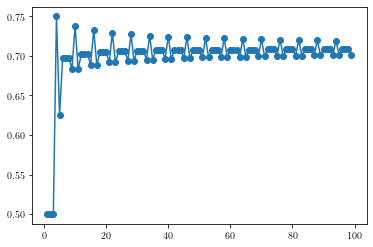

In [327]:
K = 3
D = range(1, 100)
P_d = [P(d, K) for d in D]
plt.plot(D, P_d, '-o')
plt.show()

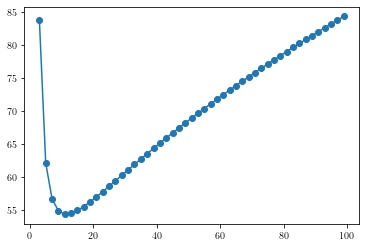

In [328]:
K_arr = [2*n + 1 for n in range(1, 50)]
coeffs = [1/(P(K + 1, K) - P(3*K + 1, K)) for K in K_arr]
plt.plot(K_arr, coeffs, '-o')

In [ ]:
print(coeffs[0], coeffs[-1])

83.76677776463379 (84.31915967805001+0j)


In [ ]:
coeffs[4]

(54.32120683464602+0j)

## Spin half

# SDP

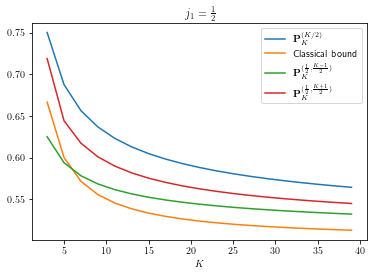

In [41]:
rg = 20
K_arr = [2*i + 1 for i in range(1, rg)]
bound_cl = [(K + 1)/(2*K) for K in K_arr]
bound_minus = np.array([ent_bound(1/2, (K-1)/2, K) for K in K_arr])
bound_plus = np.array([ent_bound(1/2, (K+1)/2, K) for K in K_arr])
PK = [P(K + 1, K) for K in K_arr]

# bound_plus_SDP = np.array([bound_sdp(1/2, (K+1)/2, K) for K in K_arr])
# bound_minus_SDP = np.array([bound_sdp(1/2, (K-1)/2, K) for K in K_arr])
plt.plot(K_arr, PK, label = f"$\mathbf{{P}}_K^{{(K/2)}}$")
plt.plot(K_arr, bound_cl, label = "Classical bound")
plt.plot(K_arr, bound_minus, label = f"$\mathbf{{P}}_K^{{(\\frac{{1}}{{2}}, \\frac{{K - 1}}{{2}})}}$")
plt.plot(K_arr, bound_plus, label = f"$\mathbf{{P}}_K^{{(\\frac{{1}}{{2}}, \\frac{{K + 1}}{{2}})}}$")
# plt.plot(K_arr, bound_plus_SDP, label = "Bound plus SDP")
# plt.plot(K_arr, bound_minus_SDP, label = "Bound minus SDP")
plt.legend()
plt.xlabel("$K$")
plt.title('$j_1 = \\frac{{1}}{{2}}$')
plt.show()
# plus_diff = bound_plus_SDP - bound_plus
# minus_diff = bound_minus_SDP - bound_minus

# print("plus diff: ", plus_diff)
# print("minus diff: ", minus_diff)

# Detecting PPTES

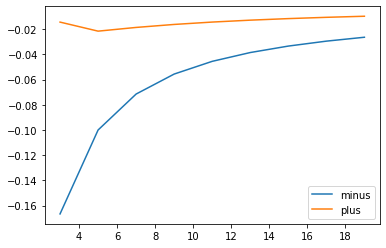

In [ ]:
def min_eig_W(j1, j2, K):
    print(K)
    d1 = int(2*j1 + 1)
    d2 = int(2*j2 + 1)
    N = d1*d2
    SK = S_func(j1, j2, K)
    beta = np.real(2*ent_bound(j1, j2, K) - 1)
    W = 1/N*(np.eye(N) - 1/beta*SK)
    W_T = pTranspose(W, d1, d2)
    return min(la.eig(W_T)[0])

K_arr = [2*i + 1 for i in range(1, 10)]
min_eig_minus = [min_eig_W(1/2, (K - 1)/2, K) for K in K_arr]
min_eig_plus = [min_eig_W(1/2, (K + 1)/2, K) for K in K_arr]
plt.plot(K_arr, min_eig_minus, label = "minus")
plt.plot(K_arr, min_eig_plus, label = "plus")
plt.legend()

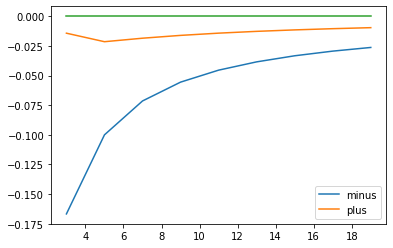

In [ ]:
plt.plot(K_arr, min_eig_minus, label = "minus")
plt.plot(K_arr, min_eig_plus, label = "plus")
plt.plot(K_arr, [0 for _ in range(len(K_arr))])
plt.legend()

In [ ]:
K = 3
j1 = 1/2
j2 = (K - 1)/2
d1 = int(2*j1 + 1)
d2 = int(2*j2 + 1)
N = d1*d2
SK = S_func(j1, j2, K)
beta = np.real(2*ent_bound(j1, j2, K) - 1)
W = 1/N*(np.eye(N) - 1/beta*SK)
W_T = pTranspose(W, d1, d2)
eig_vals = la.eig(W_T)[0]
eig_vecs = la.eig(W_T)[1]
eig_vals

array([ 0.5       , -0.16666667,  0.16666667,  0.16666667,  0.16666667,
        0.16666667])

## Decomposability of our entanglement witness


In [ ]:
K = 3
j1 = 1/2
j2 = (K - 1)/2
d1 = int(2*j1 + 1)
d2 = int(2*j2 + 1)
N = d1*d2

gm = [np.eye(N)]
pT_gm = [np.eye(N)]
for A in lp.gen_gellmann(N):
    gm.append(1j*A)
    pT_gm.append(pTranspose(1j*A, d1, d2))

SK = S_func(j1, j2, K)
beta = np.real(2*ent_bound(j1, j2, K) - 1)
W = 1/N*(np.eye(N) - 1/beta*SK)

In [ ]:
F = picos.Problem()
p = picos.RealVariable("p", (N**2, 1))
q = picos.RealVariable("q", (N**2, 1))
alpha = picos.Constant("𝛼", 0)
F.set_objective("max", alpha)
F.add_constraint(expand(p, gm) >> 0)
F.add_constraint(expand(q, gm) >> 0)
F.add_constraint(expand(p, gm) + expand(q, pT_gm) == W)
F.solve(solver = "cvxopt")
# print(F)
#     print("\nOptimal value:", round(F, 4))
#     print("Optimal y:", y.value, sep="\n")
p_opt = np.array(p.value)
q_opt = np.array(q.value)

## All possible spin

In [32]:
K = 7
j_rg = 5
bound_arr = np.zeros((int(2*j_rg), int(2*j_rg)))
for j1 in np.arange(1/2, j_rg + 1/2, 1/2):
    i1 = int(2*j1 - 1)
    for j2 in np.arange(j1, j_rg + 1/2, 1/2):
        i2 = int(2*j2 - 1)
        print(j1, j2)
        bound_arr[i1, i2] = np.real(max_sep_bound(j1, j2, K))
        bound_arr[i2, i1] = np.real(max_sep_bound(j1, j2, K))

0.5 0.5
0.5 1.0
0.5 1.5
0.5 2.0
0.5 2.5
0.5 3.0
0.5 3.5
0.5 4.0
0.5 4.5
0.5 5.0
1.0 1.0
1.0 1.5
1.0 2.0
1.0 2.5
1.0 3.0
1.0 3.5
1.0 4.0
1.0 4.5
1.0 5.0
1.5 1.5
1.5 2.0
1.5 2.5
1.5 3.0
1.5 3.5
1.5 4.0
1.5 4.5
1.5 5.0
2.0 2.0
2.0 2.5
2.0 3.0
2.0 3.5
2.0 4.0
2.0 4.5
2.0 5.0
2.5 2.5
2.5 3.0
2.5 3.5
2.5 4.0
2.5 4.5
2.5 5.0
3.0 3.0
3.0 3.5
3.0 4.0
3.0 4.5
3.0 5.0
3.5 3.5
3.5 4.0
3.5 4.5
3.5 5.0
4.0 4.0
4.0 4.5
4.0 5.0
4.5 4.5
4.5 5.0
5.0 5.0


Text(0, 0.5, '$j_2$')

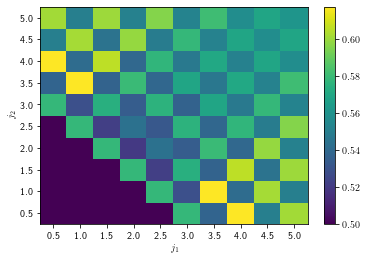

In [33]:
for i in range(int(2*j_rg)):
    for j in range(int(2*j_rg)):
        if(not bound_arr[i, j]):
            bound_arr[i, j] = 0
j_arr = np.arange(1/2, j_rg + 1/2, 1/2)
fig, ax = plt.subplots()
# im = ax.imshow(bound_arr)
X, Y = np.meshgrid(range(int(2*j_rg)),range(int(2*j_rg)))
plt.pcolor(X, Y, bound_arr, cmap='viridis')
plt.colorbar()
ax.set_xticks(range(int(2*j_rg)), labels = [str(_) for _ in j_arr])
ax.set_yticks(range(int(2*j_rg)), labels = [str(_) for _ in j_arr])
plt.xlabel('$j_1$')
plt.ylabel('$j_2$')
# cbar = ax.figure.colorbar(im, )

In [34]:
barr = bound_arr

In [35]:
barr

array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       , 0.578125  , 0.53738698, 0.6171875 , 0.55026773, 0.60093868],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.578125  , 0.52850278, 0.6171875 , 0.540762  , 0.60146893, 0.55019585],
       [0.5       , 0.5       , 0.5       , 0.578125  , 0.5218366 , 0.57390602, 0.53688301, 0.60564731, 0.54467281, 0.59989249],
       [0.5       , 0.5       , 0.578125  , 0.51953125, 0.5436732 , 0.53395469, 0.5794154 , 0.5392826 , 0.59854692, 0.55102924],
       [0.5       , 0.578125  , 0.5218366 , 0.5436732 , 0.5316946 , 0.57547488, 0.53885566, 0.57664404, 0.54858828, 0.595484  ],
       [0.578125  , 0.52850278, 0.57390602, 0.53395469, 0.57547488, 0.53625747, 0.56882269, 0.54738582, 0.57797848, 0.55220105],
       [0.53738698, 0.6171875 , 0.53688301, 0.5794154 , 0.53885566, 0.56882269, 0.54633893, 0.57036757, 0.55185058, 0.58086255],
       [0.6171875 , 0.540762  , 0.60564731, 0.5392826 , 0.57664404, 0.54738582, 0.57036757, 0.551

# SPI

In [ ]:
def is_convergent(L, a, b, tol = 1e-4):
    d1 = len(a)
    d2 = len(b)
    j1 = (d1 - 1)/2
    j2 = (d2 - 1)/2
    vec = np.kron(a, b)
    g = hermitian(vec) @ L @ vec
    xi = (L - g*np.eye(d1*d2)) @ vec
    # print("xi =", xi)
    B1 = [ket(j1, m) for m in np.arange(-j1, j1 + 1, 1)]
    err1 = max([np.abs(np.kron(hermitian(x), hermitian(b)) @ xi) for x in B1])
    if(d2 == 1):
        # print("err1: ", err1)
        return (err1 < tol)
    else:
        B2 = [ket(j2, m) for m in np.arange(-j2, j2 + 1, 1)]
        err2 = max([np.abs(np.kron(hermitian(a), hermitian(x)) @ xi) for x in B2])
        # print("err1: ", err1)
        # print("err2: ", err2)
        return (max(err1, err2) < tol)

def SPI(j1, j2, K):
    #work only for bipartitite system because of the implementation of pTranspose()
    
    d1 = int(2*j1 + 1)
    d2 = int(2*j2 + 1)
    L = S_func(j1, j2, K) + np.eye(d1*d2)

    start_vec_1 = gellmann_eig_vec(d1)
    start_vec_2 = gellmann_eig_vec(d2)
    bound = 0
    m = 0
    for a in start_vec_1:
        for b in start_vec_2:
            print("m =", m)
            m += 1
            fail = 0
            vec = np.kron(a, b)
            isc = is_convergent(L, a, b)
            num_iter = 200
            iter = 0
            while(not isc):
                if(iter == num_iter):
                    print("failed to converge")
                    fail += 1
                    break
                psi = L @ vec
                L_p = pTrace2(psi @ hermitian(psi), d1, d2) + np.eye(d1)
                bound_p = 0
                for a_p in start_vec_1:
                    isc_p = is_convergent(L_p, a_p, np.array([1]))
                    iter_p = 0
                    while(not isc_p):
                        if(iter_p == num_iter):
                            # print("small loop not converge")
                            break
                        a_p = L_p @ a_p
                        # print("a_p =", a_p)
                        a_p = a_p/la.norm(a_p)
                        isc_p = is_convergent(L_p, a_p, np.array([1]))
                        # print("iter_p =", iter_p)
                        iter_p += 1
                    new_bound_p = hermitian(a_p) @ L_p @ a_p
                    if(new_bound_p > bound_p):
                        bound_p = new_bound_p
                        a_p_opt = a_p
                a = a_p_opt
                b = np.kron(hermitian(a), np.eye(d2)) @ psi
                if(num_iter - iter < 6):
                    print("a =", a)
                    print("b =", b)
                b = b/la.norm(b)
                isc = is_convergent(L, a, b)
                # print("iter =", iter)
                iter += 1
                vec = np.kron(a, b)

            new_bound = hermitian(vec) @ L @ vec
            # print("new bound =", new_bound)
            # print("vec =", vec.reshape((d1*d2,)))
            bound = max(bound, new_bound)
    return 1/2*bound

In [ ]:
K = 5
j1 = 1/2
j2 = (K + 1)/2
SPI(j1, j2, K)

# Effect of noise on the protocol

## Pure dephasing: $L = \sqrt{\lambda} J_z$

In [ ]:
#A(kT)
def time_evol_pure_dephasing(A, k, eta, density_mat = False):
    d = np.shape(A)[0]
    A_k = np.zeros((d, d), dtype = complex)
    if(density_mat):
        for m in range(d):
            for n in range(d):
                A_k[m, n] = np.exp( -2*np.pi*k*(eta*(m - n)**2 + 1j*(m - n))) * A[m, n]
    else:
        for m in range(d):
            for n in range(d):
                A_k[m, n] = np.exp( -2*np.pi*k*(eta*(m - n)**2 - 1j*(m - n))) * A[m, n]
    return A_k 

def E_func_dephasing(d, K, eta, s = 1):
    # eta = gamma/omega
    E_pos = 1/2*(np.eye(d) + sgnJx(d))
    E_damped = np.zeros((d, d), dtype = complex)
    for p in range(K):
        E_damped += time_evol_pure_dephasing(E_pos, s*p/K, eta)
    return E_damped/K

def P_dephasing(d, K, eta, s = 1):
    eig_vals, eig_vecs = la.eig(E_func_dephasing(d, K, eta, s))
    max_val = max(eig_vals)
    max_vec = eig_vecs[:, np.argmax(eig_vals)]
    return max_val

def optimal_vec_dephasing(d, K, eta, s = 1):
    eig_vals, eig_vecs = la.eig(E_func_dephasing(d, K, eta, s))
    max_vec = eig_vecs[:, np.argmax(eig_vals)]
    return np.reshape(max_vec, (d, 1))

def prepared_state_dephasing(d, K, eta, s = 1):
    state = optimal_vec(d, K)
    expectation_val = hermitian(state) @ E_func_dephasing(d, K, eta, s) @ state
    return expectation_val

/home/khoinguyen/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


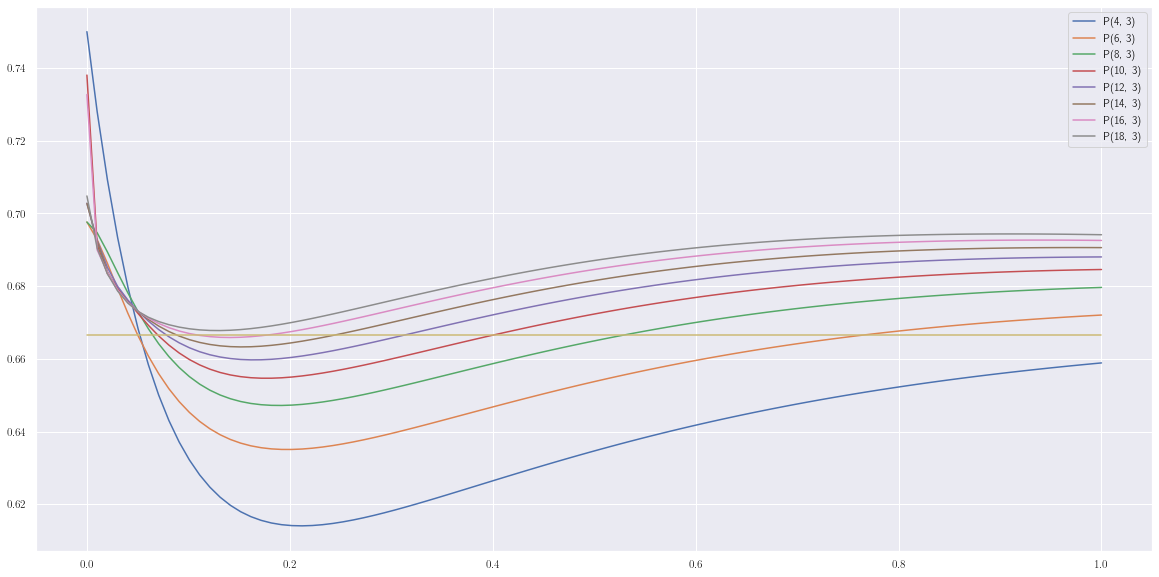

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
K = 3
eta_arr = np.linspace(0, 1, 100)
for d in range(2, 10):
    P_arr = [P_dephasing(2*d, 3, eta) for eta in eta_arr]
    plt.plot(eta_arr, P_arr, label = f"P({2*d}, {K})")
plt.plot(eta_arr, [2/3 for _ in eta_arr])
plt.legend()

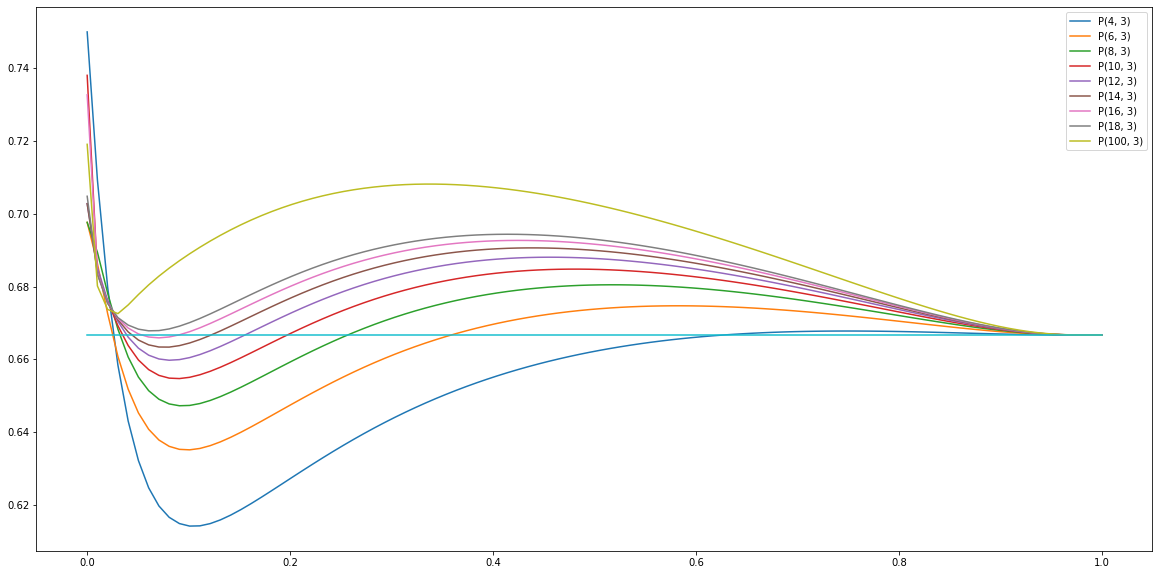

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
K = 3
eta_arr = np.linspace(0, 1 - 1e-4, 100)
for d in [*range(2, 10)] + [50]:
    P_arr = [P_dephasing(2*d, 3, eta) for eta in eta_arr]
    plt.plot(eta_arr, P_arr, label = f"P({2*d}, {K})")
plt.plot(eta_arr, [2/3 for _ in eta_arr])
plt.legend()


50


/home/khoinguyen/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


100
150
200
250
300
350
400
450


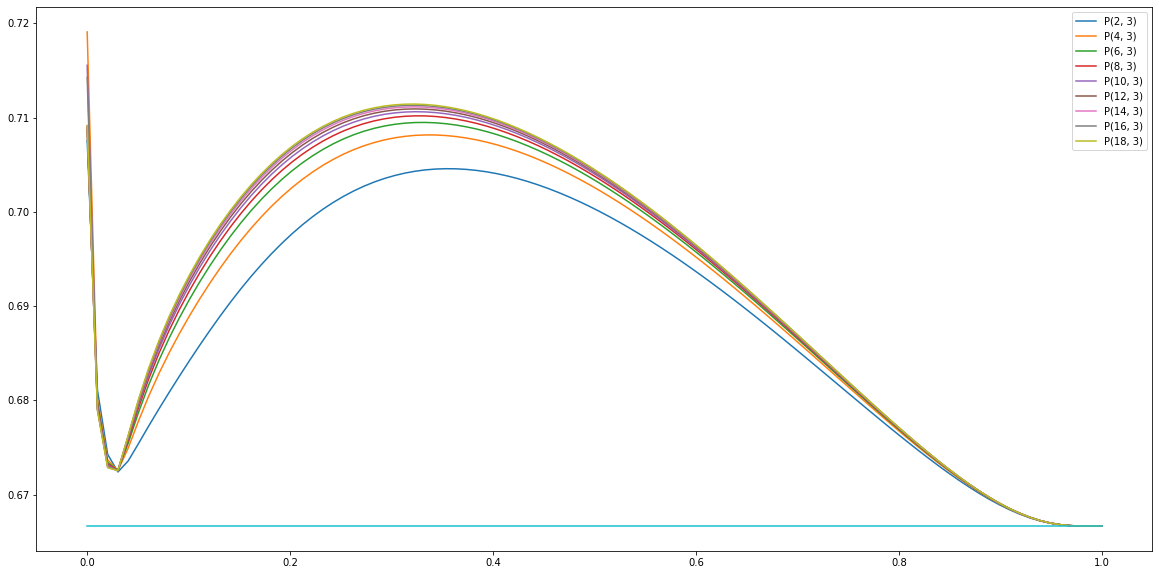

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
K = 3
eta_arr = np.linspace(0, 1 - 1e-4, 100)
for d in range(1, 10):
    P_arr = [P_dephasing(50*d, 3, eta) for eta in eta_arr]
    plt.plot(eta_arr, P_arr, label = f"P({2*d}, {K})")
plt.plot(eta_arr, [2/3 for _ in eta_arr])
plt.legend()

### Changing probing time $\left\{s\frac{k}{K}T \right\}_{k = 0}^{K - 1}$

In [ ]:
d = 8
K = 7

In [ ]:
dim = 100
rg = 1
s_rg = np.linspace(3/4, 3/2, dim)
eta_rg = np.linspace(0, rg, dim)
hmap = np.zeros((dim, dim), dtype = complex)
for m in range(dim):
    sys.stdout.write("\rCalculating " + str(round(m/dim*100)) + "%")
    sys.stdout.flush()
    for n in range(dim):
        hmap[m, n] = P_dephasing(d, K, eta_rg[n], s_rg[m])

/home/khoinguyen/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 48.75875865893524, '$\\eta_0$'),
 Text(765.4860313862077, 0.5, '$s$')]

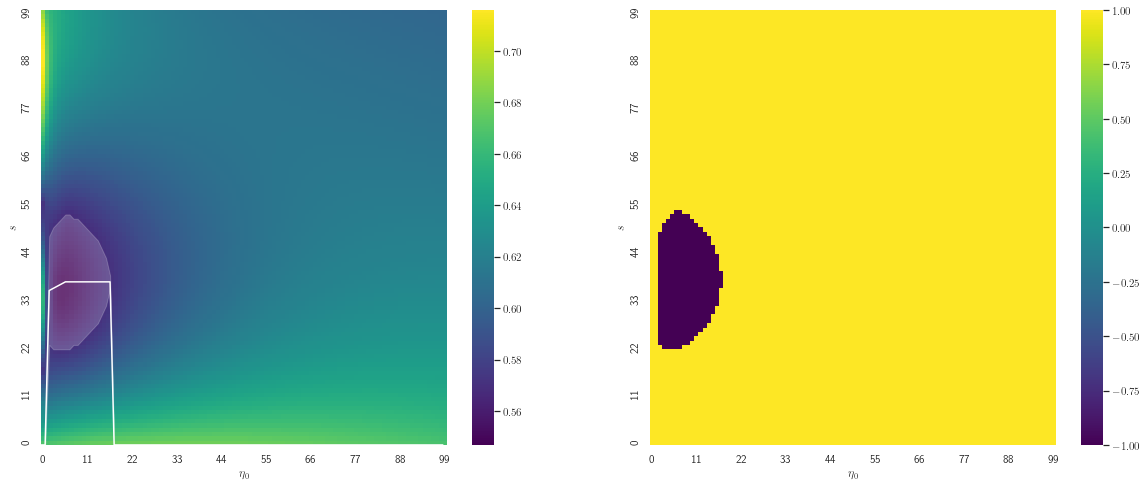

In [ ]:
sns.set(rc={'figure.figsize':(10, 8), 'text.usetex':'True'})
num_ticks = 10

cl_bound = 1/2 + 1/(2*K)

sgn_hmap = np.zeros((dim, dim))
for m in range(dim):
    for n in range(dim):
        sgn_hmap[m, n] = np.sign(np.real(hmap[m, n]) - cl_bound)

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20,8))

f0 = sns.heatmap(np.real(hmap), ax = ax[0], cmap = 'viridis', xticklabels=11, yticklabels=11)
cl_line_x = np.zeros((2*dim,))
cl_line_y = np.zeros((2*dim,))

for n in range(dim):
    cl_line_x[2*n] = n 
    cl_line_x[2*n + 1] = n
    ind = [i for i in range(dim) if hmap[i, n] < cl_bound]
    if(ind):
        cl_line_y[2*n] = min(ind)
        cl_line_y[2*n + 1] = max(ind)
sns.lineplot(cl_line_x, cl_line_y, ax = ax[0], color = 'w')
f0.axes.invert_yaxis()
f0.set(xlabel = "$\eta_0$", ylabel = "$s$")

f1 = sns.heatmap(sgn_hmap, ax = ax[1], cmap = 'viridis', xticklabels=11, yticklabels=11)
f1.axes.invert_yaxis()
f1.set(xlabel = "$\eta_0$", ylabel = "$s$")

/home/khoinguyen/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


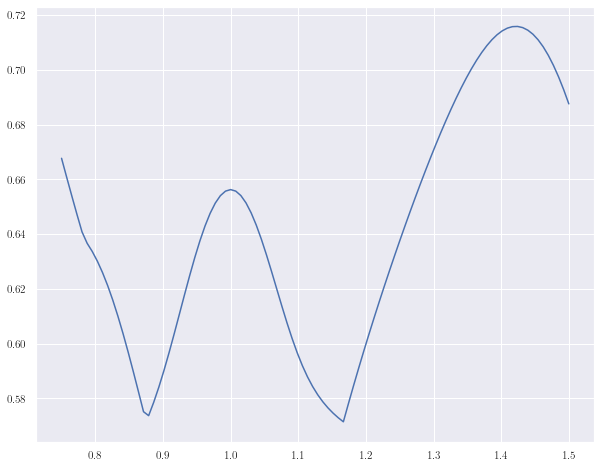

In [ ]:
plt.plot(s_rg, hmap[:, 0])

In [ ]:
from scipy.signal import argrelextrema
local_max_ind = argrelextrema(hmap[:, 0], np.greater)[0]
s_arr  = [s_rg[i] for i in local_max_ind]
s_arr

[1.0, 1.4242424242424243]

In [ ]:
vec = optimal_vec_dephasing(d, K, 0, 1)
rho = vec @ hermitian(vec)
theta_arr, phi_arr, wigner_psi = plot_wigner(rho, 25, 4)

### Prepared state evolution

In [ ]:
d = 8
K = 3
dim = 100
rg = 0.025
s_rg = np.linspace(3/4, 3/2, dim)
eta_rg = np.linspace(0, rg, dim)
hmap = np.zeros((dim, dim), dtype = complex)
for m in range(dim):
    sys.stdout.write("\rCalculating " + str(round(m/dim*100)) + "%")
    sys.stdout.flush()
    for n in range(dim):
        hmap[m, n] = prepared_state_dephasing(d, K, eta_rg[n], s_rg[m])

Calculating 99%

/home/khoinguyen/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 48.75875865893524, '$\\eta_0$'),
 Text(765.4860313862077, 0.5, '$s$')]

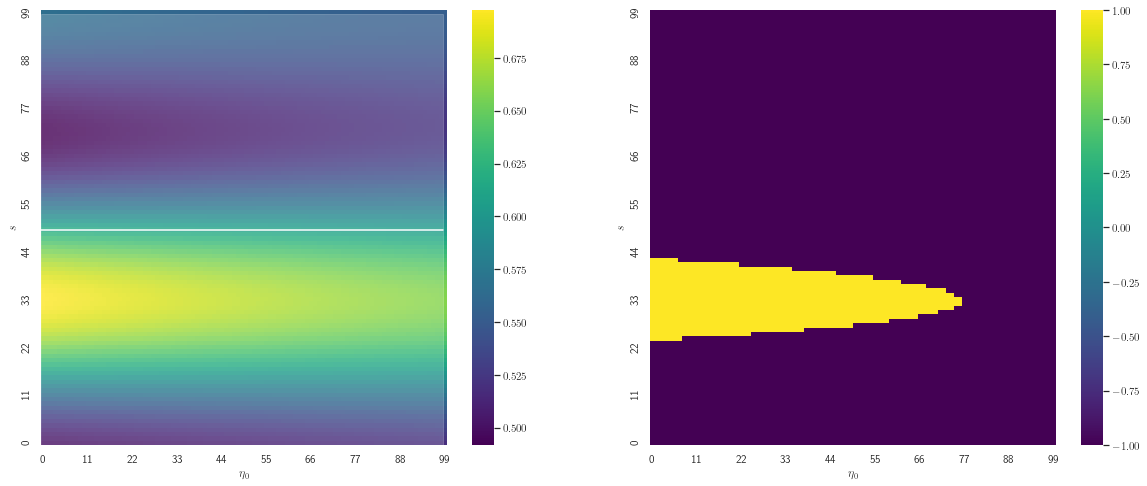

In [ ]:
sns.set(rc={'figure.figsize':(10, 8), 'text.usetex':'True'})
num_ticks = 10

cl_bound = 1/2 + 1/(2*K)

sgn_hmap = np.zeros((dim, dim))
for m in range(dim):
    for n in range(dim):
        sgn_hmap[m, n] = np.sign(np.real(hmap[m, n]) - cl_bound)

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20,8))

f0 = sns.heatmap(np.real(hmap), ax = ax[0], cmap = 'viridis', xticklabels=11, yticklabels=11)
cl_line_x = np.zeros((2*dim,))
cl_line_y = np.zeros((2*dim,))

for n in range(dim):
    cl_line_x[2*n] = n 
    cl_line_x[2*n + 1] = n
    ind = [i for i in range(dim) if hmap[i, n] < cl_bound]
    if(ind):
        cl_line_y[2*n] = min(ind)
        cl_line_y[2*n + 1] = max(ind)
sns.lineplot(cl_line_x, cl_line_y, ax = ax[0], color = 'w')
f0.axes.invert_yaxis()
f0.set(xlabel = "$\eta_0$", ylabel = "$s$")

f1 = sns.heatmap(sgn_hmap, ax = ax[1], cmap = 'viridis', xticklabels=11, yticklabels=11)
f1.axes.invert_yaxis()
f1.set(xlabel = "$\eta_0$", ylabel = "$s$")

/home/khoinguyen/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


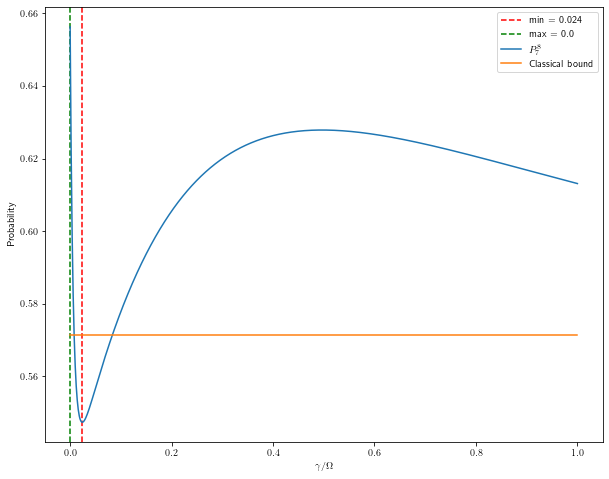

In [ ]:
d = 8
K = 7
plt.rcParams["figure.figsize"] = (10, 8)
eta_arr = np.linspace(0, 1, 1001)
P_arr = [P_dephasing(d, K, eta) for eta in eta_arr]
eta_min = eta_arr[np.argmin(P_arr)]
eta_max = eta_arr[np.argmax(P_arr)]
plt.axvline(eta_min, color = 'r', linestyle = '--', label = f'min = {eta_min}')
plt.axvline(eta_max, color = 'g', linestyle = '--', label = f'max = {eta_max}')
plt.plot(eta_arr, P_arr, label = f"$P^{d}_{K}$")
plt.plot(eta_arr, [1/2 + 1/(2*K) for _ in eta_arr], label = "Classical bound")
plt.xlabel("$\gamma/\Omega$")
plt.ylabel("Probability")
plt.legend()



In [ ]:
eta_arr = np.linspace(0, 10, 1001)
sgn_arr = [[] for _ in range(K)]
for k in range(K):
    for eta in eta_arr:
        init_state = optimal_vec_dephasing(d, K, eta, 1)
        init_rho = init_state @ hermitian(init_state)
        rho_k = time_evol_pure_dephasing(init_rho, k/K, eta, True)
        sgn_arr[k].append(np.real(tr(rho_k @ sgnJx(d))))
np.shape(sgn_arr)

(7, 1001)

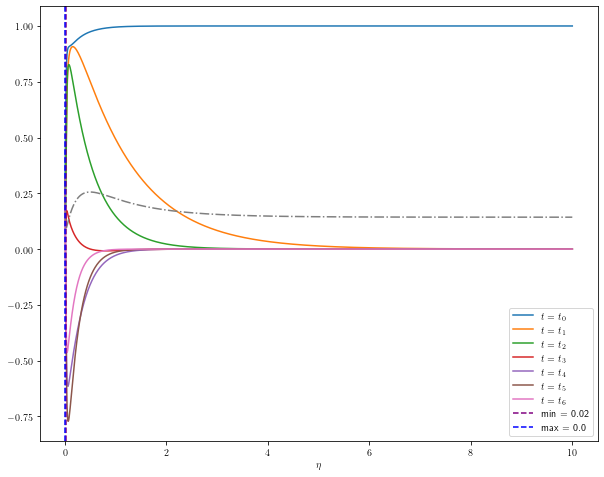

In [ ]:
for k in range(K):
    plt.plot(eta_arr, sgn_arr[k], label = f'$t = t_{k}$')
P_arr = [2*P_dephasing(d, K, eta) - 1 for eta in eta_arr]
eta_min = eta_arr[np.argmin(P_arr)]
eta_max = eta_arr[np.argmax(P_arr)]
plt.plot(eta_arr, P_arr, linestyle = "-.")
plt.axvline(eta_min, color = 'purple', linestyle = '--', label = f'min = {eta_min}')
plt.axvline(eta_max, color = 'blue', linestyle = '--', label = f'max = {eta_max}')
plt.xlabel("$\eta$")
plt.legend()

In [ ]:
sgn_arr[4][0]

0.2858463504212954

In [ ]:
d = 8
K = 7
eta = 0.4
init_state = optimal_vec_dephasing(d, K, eta, 1)
init_rho = init_state @ hermitian(init_state)
rho = [time_evol_pure_dephasing(init_rho, k/K, eta, True) for k in range(K)]

resolution = [720, 60]

Calculating 100%

/tmp/ipykernel_460/1717490164.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/1717490164.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/1717490164.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/1717490164.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

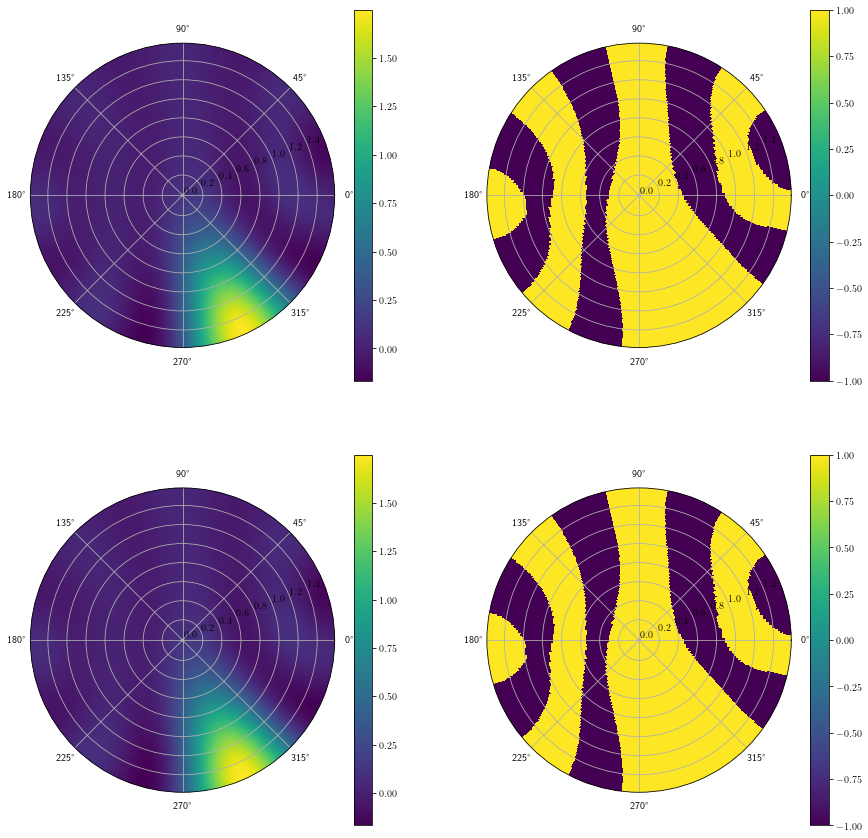

In [ ]:
plot_wigner(rho[0], *resolution)

Calculating 100%

/tmp/ipykernel_460/2988134256.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

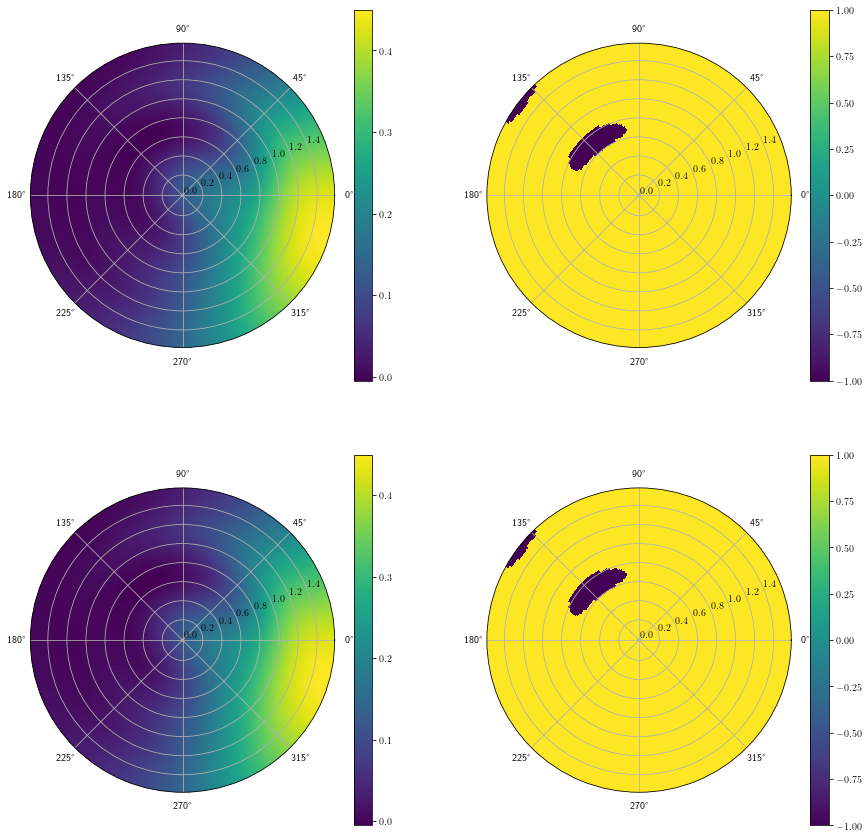

In [ ]:
plot_wigner(rho[1], *resolution)

Calculating 100%

/tmp/ipykernel_460/2988134256.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

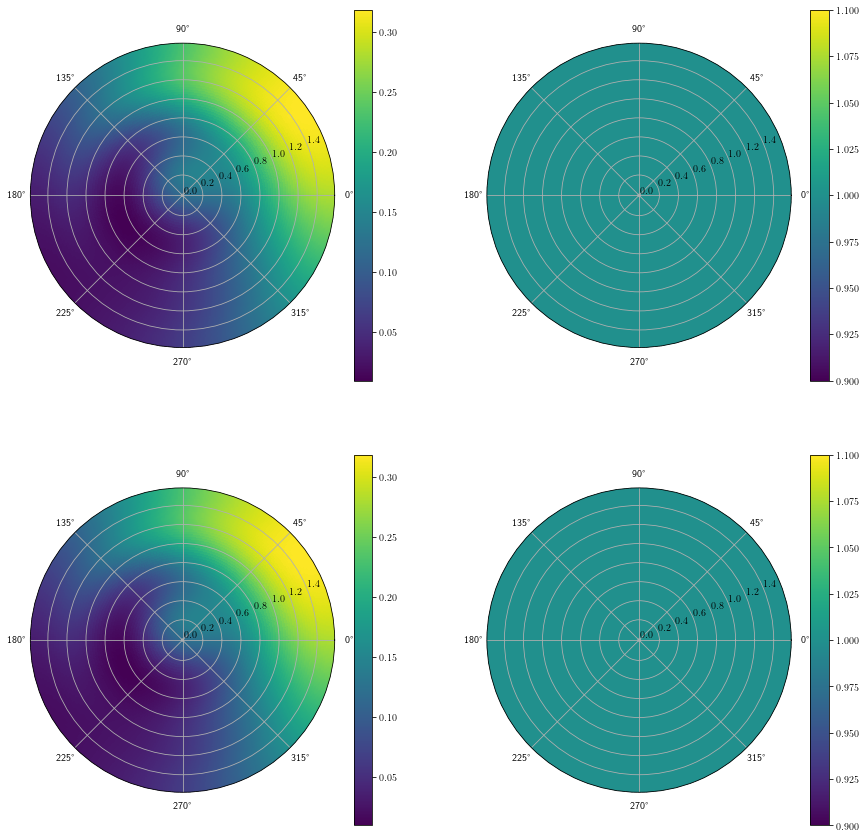

In [ ]:
plot_wigner(rho[2], *resolution)

Calculating 100%

/tmp/ipykernel_460/2988134256.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

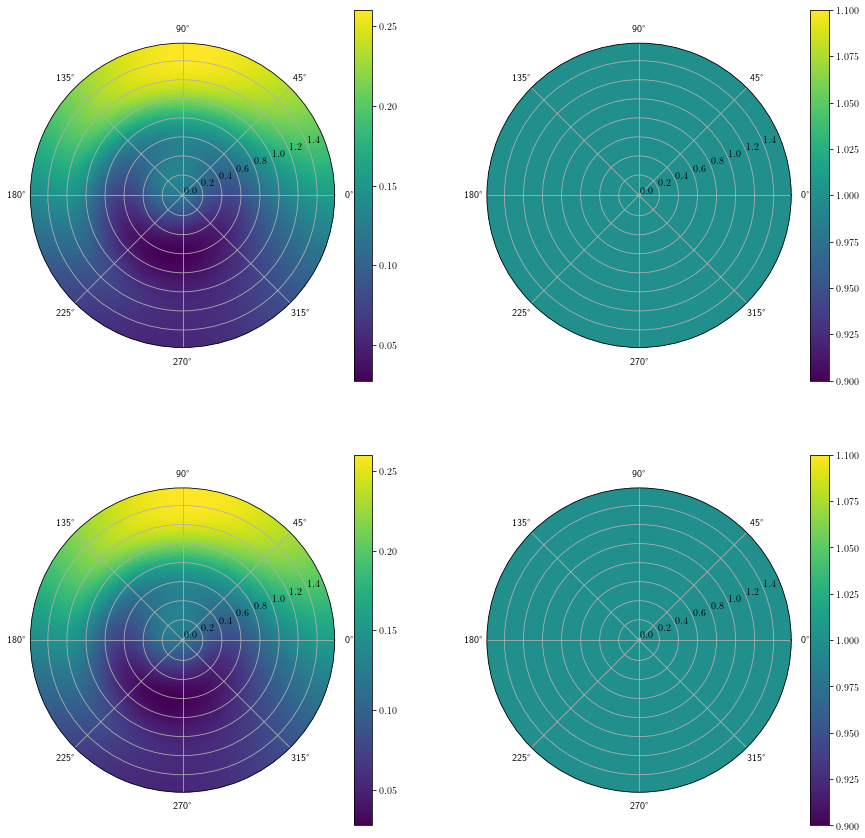

In [ ]:
plot_wigner(rho[3], *resolution)

Calculating 100%

/tmp/ipykernel_460/2988134256.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

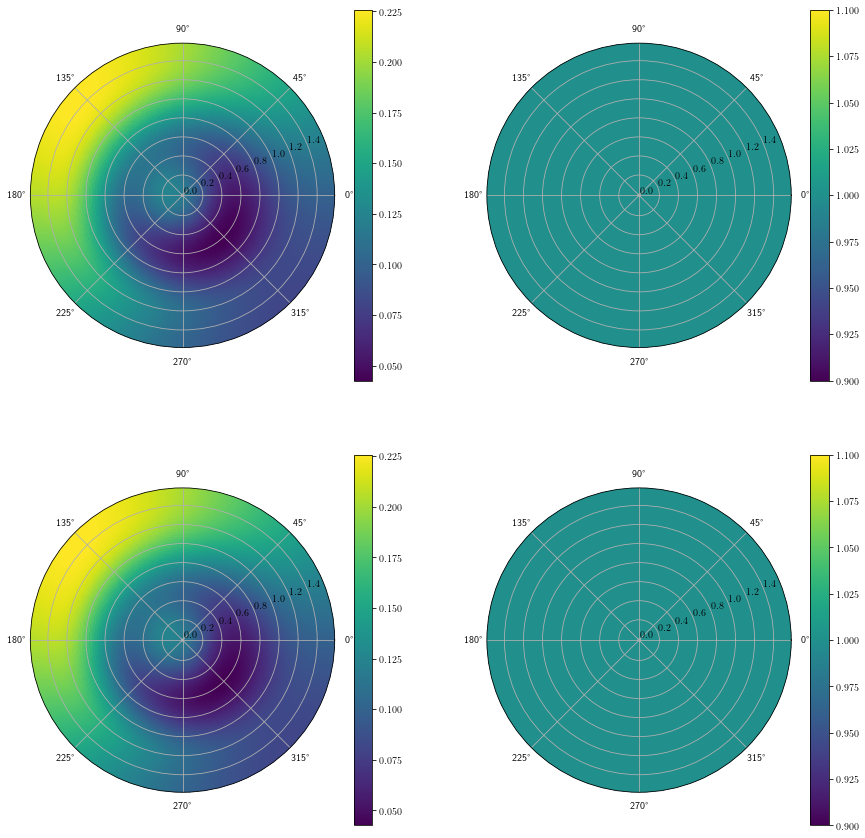

In [ ]:
plot_wigner(rho[4], *resolution)

Calculating 100%

/tmp/ipykernel_460/2988134256.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

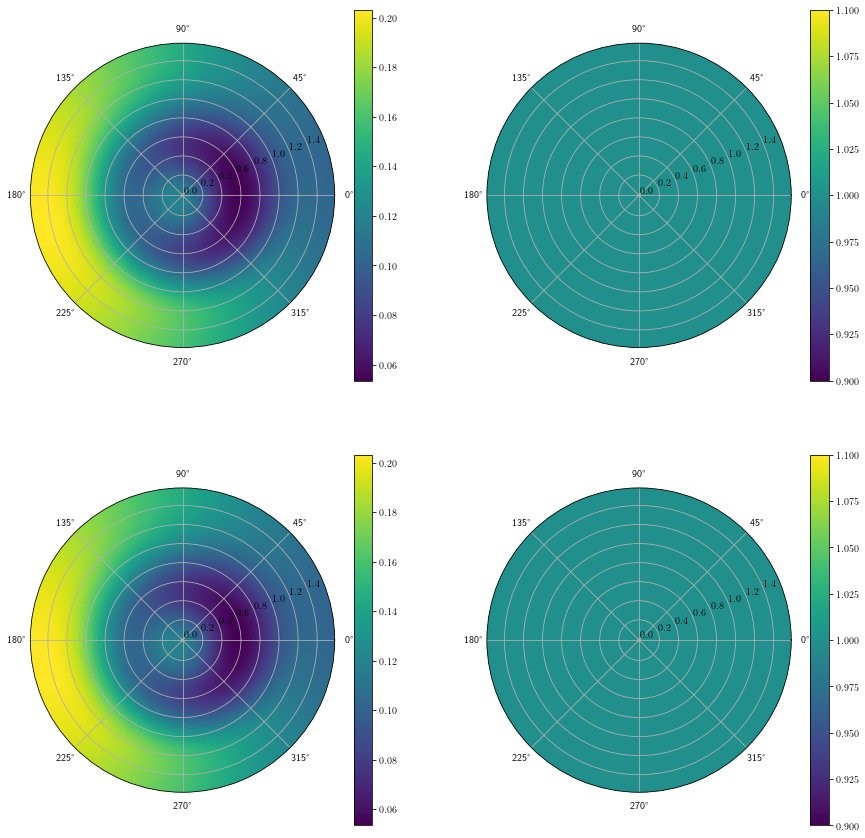

In [ ]:
plot_wigner(rho[5], *resolution)

Calculating 100%

/tmp/ipykernel_460/2988134256.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/2988134256.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

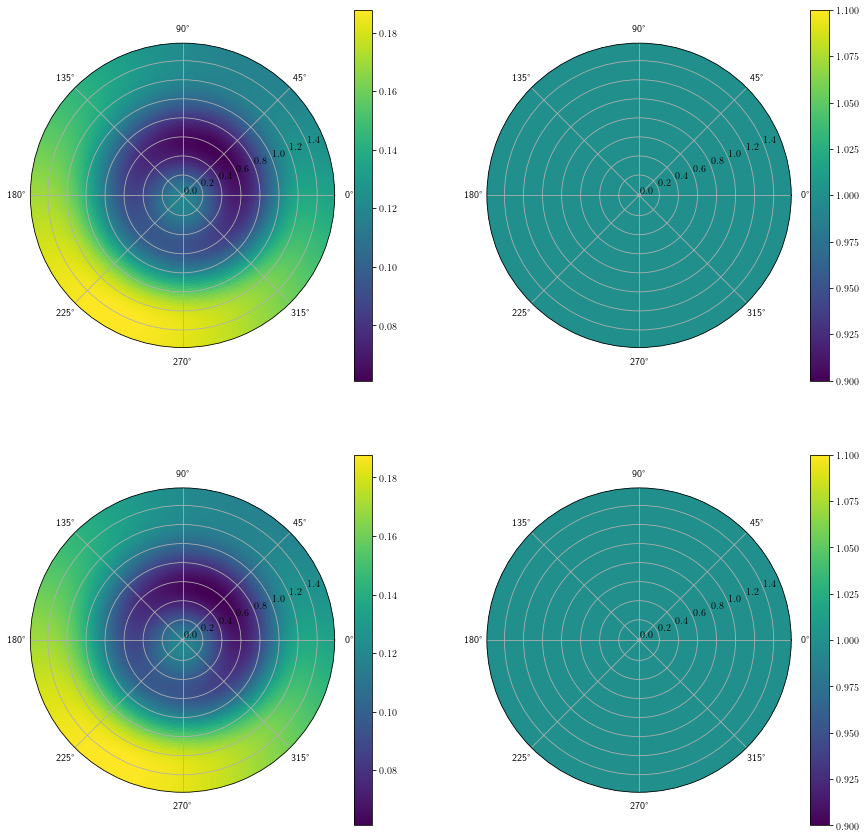

In [ ]:
plot_wigner(rho[6], *resolution)

## Dephasing and relaxation: $L_1 = \sqrt{\lambda} J_z, L_2 = \sqrt{\mu} J_-$

In [ ]:
I = sp.I

def alpha(j, m):
    j = sp.Rational(j)
    m = sp.Rational(m)
    return sp.sqrt(j * (j + 1) - m * (m + 1))

def beta(j, m):
    j = sp.Rational(j)
    m = sp.Rational(m)
    return sp.sqrt(j * (j + 1) - m * (m - 1))
    
def a(m, n, j, omega, gamma_0, gamma_m):
    j = sp.Rational(j)
    m = sp.Rational(m)
    n = sp.Rational(n)
    return (I*omega*(m - n) - gamma_0*(m - n)**2 - gamma_m/2*(beta(j, m)**2 + beta(j, n)**2))

def b(m, n, j, gamma_m):
    j = sp.Rational(j)
    m = sp.Rational(m)
    n = sp.Rational(n)
    return gamma_m*alpha(j, m - 1)*alpha(j, n - 1)


def time_evol_relaxation(A, m, n, j, omega, gamma_0, gamma_m, t):
    s = sp.symbols('s')
    if(m == -j or n == -j):
        return A[index(j, m), index(j, n)]*sp.exp(a(m, n, j, omega, gamma_0, gamma_m)*t)
    else:
        return (A[index(j, m), index(j, n)] + b(m, n, j, gamma_m)*sp.integrate(time_evol_relaxation(A, m - 1, n - 1, j, omega, gamma_0, gamma_m, s)*sp.exp(-a(m, n, j, omega, gamma_0, gamma_m)*s), (s, 0, t)) )*sp.exp(a(m, n, j, omega, gamma_0, gamma_m)*t)

def sgnJx_sp(d):
    S = sgnJx(d)
    S_ = sp.zeros(d, d)
    for m in range(d):
        for n in range(d):
            S_[m, n] = sp.sqrt(round(2**(2*d)*S[m, n]**2))/2**d*sp.sign(S[m, n])
    return S_

### Analytic solution in time $t$

In [ ]:
omega, gamma_0, gamma_m, t = symbols('\omega \gamma_0 \gamma_- t', positive = True)
j = 7/2
d = int(2*j + 1)
A = sp.zeros(d, d)
S = sgnJx_sp(d)
gamma_m = 0
for m in range(d):
    for n in range(d):
        A[m, n] = sp.expand(time_evol_relaxation(S, m - j, n - j, j, omega, gamma_0, gamma_m, t))


In [ ]:
A

Matrix([
[                                                0,   5*sqrt(7)*exp(-\gamma_0*t)*exp(-I*\omega*t)/16,                                                 0, -sqrt(35)*exp(-9*\gamma_0*t)*exp(-3*I*\omega*t)/16,                                                 0, sqrt(21)*exp(-25*\gamma_0*t)*exp(-5*I*\omega*t)/16,                                                 0,       -5*exp(-49*\gamma_0*t)*exp(-7*I*\omega*t)/16],
[    5*sqrt(7)*exp(-\gamma_0*t)*exp(I*\omega*t)/16,                                                0,    5*sqrt(3)*exp(-\gamma_0*t)*exp(-I*\omega*t)/16,                                                  0, -sqrt(5)*exp(-9*\gamma_0*t)*exp(-3*I*\omega*t)/16,                                                  0,         exp(-25*\gamma_0*t)*exp(-5*I*\omega*t)/16,                                                  0],
[                                                0,    5*sqrt(3)*exp(-\gamma_0*t)*exp(I*\omega*t)/16,                                                 0,    3*sqrt(15)*

### Analytic solution in period $kT$

In [ ]:
omega, eta_0, eta_m, k = symbols('\omega \eta_0 \eta_- k', positive = True)
j = 3/2
d = int(2*j + 1)
A = sp.zeros(d, d)
S = sgnJx_sp(d)
eta_m = 0
for m in range(d):
    for n in range(d):
        A[m, n] = sp.expand(time_evol_relaxation(S, m - j, n - j, j, omega, eta_0*omega, eta_m*omega, 2*sp.pi*k/omega))

In [ ]:
A

Matrix([
[                                          0, sqrt(3)*exp(-2*I*pi*k)*exp(-2*pi*\eta_0*k)/2,                                           0,       -exp(-6*I*pi*k)*exp(-18*pi*\eta_0*k)/2],
[sqrt(3)*exp(2*I*pi*k)*exp(-2*pi*\eta_0*k)/2,                                            0,        exp(-2*I*pi*k)*exp(-2*pi*\eta_0*k)/2,                                            0],
[                                          0,          exp(2*I*pi*k)*exp(-2*pi*\eta_0*k)/2,                                           0, sqrt(3)*exp(-2*I*pi*k)*exp(-2*pi*\eta_0*k)/2],
[      -exp(6*I*pi*k)*exp(-18*pi*\eta_0*k)/2,                                            0, sqrt(3)*exp(2*I*pi*k)*exp(-2*pi*\eta_0*k)/2,                                            0]])

### Score for probing times $\left\{\frac{k}{K}T \right\}_{k = 0}^{K - 1}$

In [ ]:
def sgn_Jx_evol_relaxation(d):
    omega, eta_0, eta_m, k = symbols('\omega \eta_0 \eta_- k', positive = True)
    j = (d - 1)/2
    A = sp.zeros(d, d)
    S = sgnJx_sp(d)
    for m in range(d):
        for n in range(d):
            A[m, n] = sp.expand(time_evol_relaxation(S, m - j, n - j, j, omega, eta_0*omega, eta_m*omega, 2*sp.pi*k/omega))
    f = sp.lambdify([eta_0, eta_m, k], A)
    return f
def P_relaxation(sgn_Jx, d, K, eta_0, eta_m):
    Q_K = np.zeros((d, d), dtype = complex)
    for k in range(K):
        Q_K += sgn_Jx(eta_0, eta_m, k/K)
    Q_K = Q_K/K
    eig_vals, eig_vecs = la.eig(Q_K)
    max_val = max(eig_vals)
    return 1/2*(1 + max_val)

def prepared_state_relaxation(sgn_Jx, d, K, eta_0, eta_m):
    Q_K = np.zeros((d, d), dtype = complex)
    for k in range(K):
        Q_K += sgn_Jx(eta_0, eta_m, k/K)
    Q_K = Q_K/K
    state = optimal_vec(d, K)
    expectation_val = hermitian(state) @ Q_K @ state
    return 1/2*(1 + expectation_val)

In [ ]:
d = 4
K = 3
sgn_Jx = sgn_Jx_evol_relaxation(d)

/home/khoinguyen/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


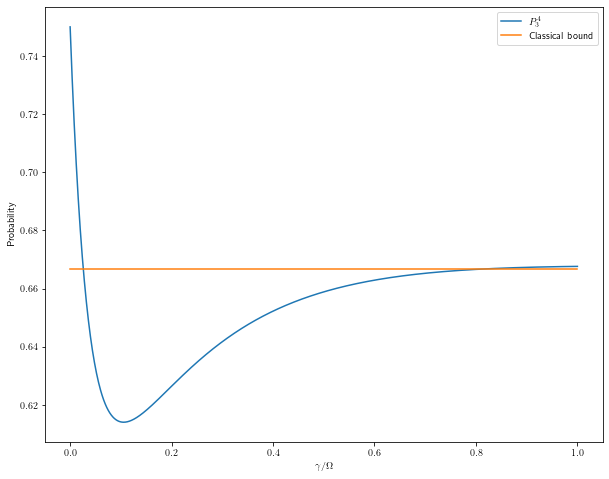

In [ ]:
plt.rcParams["figure.figsize"] = (10, 8)
eta_arr = np.linspace(0, 1, 1001)
P_arr = [P_relaxation(sgn_Jx, d, K, eta, 0) for eta in eta_arr]
plt.plot(eta_arr, P_arr, label = f"$P^{d}_{K}$")
plt.plot(eta_arr, [1/2 + 1/(2*K) for _ in eta_arr], label = "Classical bound")
plt.xlabel("$\gamma/\Omega$")
plt.ylabel("Probability")
plt.legend()

In [ ]:
eta_min = eta_arr[np.argmin(P_arr)]
eta_max = eta_arr[np.argmax(P_arr)]
print(eta_min, eta_max)

0.106 0.0


In [ ]:
d = 8
K = 7
sgn_Jx = sgn_Jx_evol_relaxation(d)

In [ ]:
dim = 100
rg_0 = 1
rg_m = 0.4
hmap = np.zeros((dim, dim), dtype = complex)
eta_0_rg = np.linspace(0, rg_0, dim)
eta_m_rg = np.linspace(0, rg_m, dim)
for m in range(dim):
    sys.stdout.write("\rCalculating " + str(round(m/dim*100)) + "%")
    sys.stdout.flush()
    for n in range(dim):
        hmap[m, n] = P_relaxation(sgn_Jx, d, K, eta_0_rg[m], eta_m_rg[n])


Calculating 99%

/home/khoinguyen/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

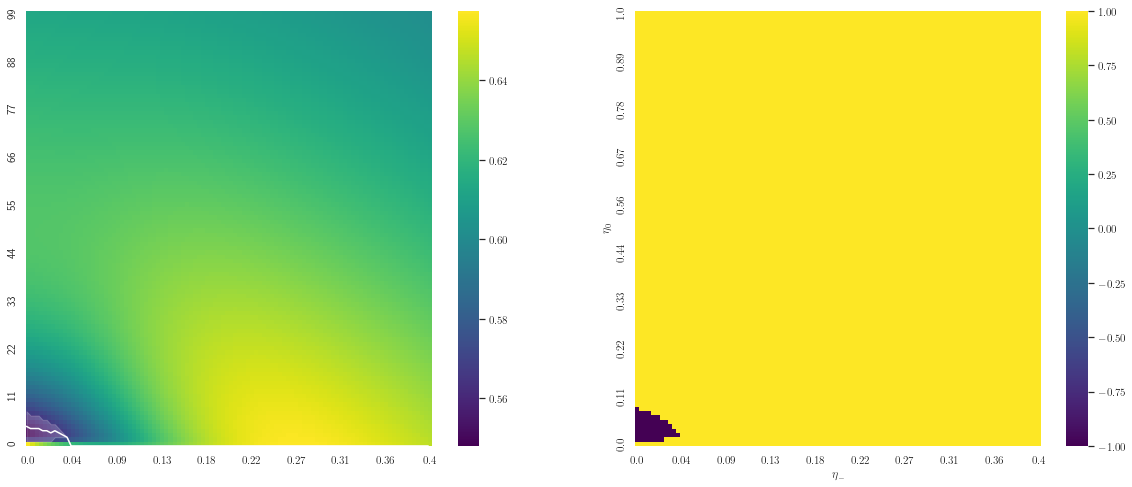

In [ ]:
sns.set(rc={'figure.figsize':(10, 8), 'text.usetex':'True'})
num_ticks = 10

cl_bound = 1/2 + 1/(2*K)

sgn_hmap = np.zeros((dim, dim))
for m in range(dim):
    for n in range(dim):
        sgn_hmap[m, n] = np.sign(np.real(hmap[m, n]) - cl_bound)

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20,8))

sns.heatmap(np.real(hmap), ax = ax[0], cmap = 'viridis', xticklabels=11, yticklabels=11)
ax[0].axes.invert_yaxis()

ax[1] = sns.heatmap(sgn_hmap, ax = ax[1], cmap = 'viridis', xticklabels=11, yticklabels=11)
ax[1].axes.invert_yaxis()

plt.xlabel("$\eta_-$")
plt.ylabel("$\eta_0$")
x_ticks = [f"${round(a, 2)}$" for a in np.linspace(0, rg_m, num_ticks)]
y_ticks = [f"${round(a, 2)}$" for a in np.linspace(0, rg_0, num_ticks)]
plt.yticks(plt.yticks()[0], y_ticks)
plt.xticks(plt.xticks()[0], x_ticks)

cl_line_x = np.zeros((2*dim,))
cl_line_y = np.zeros((2*dim,))
threshold = 1/2*(1 + 1/K) + 10**(-2.5)
for n in range(dim):
    cl_line_x[2*n] = n 
    cl_line_x[2*n + 1] = n
    ind = [i for i in range(dim) if hmap[i, n] < cl_bound]
    if(ind):
        cl_line_y[2*n] = min(ind)
        cl_line_y[2*n + 1] = max(ind)
sns.lineplot(cl_line_x, cl_line_y, ax = ax[0], color = 'w')


#### $\gamma_0 = 0$

Text(0, 0.5, 'Probability')

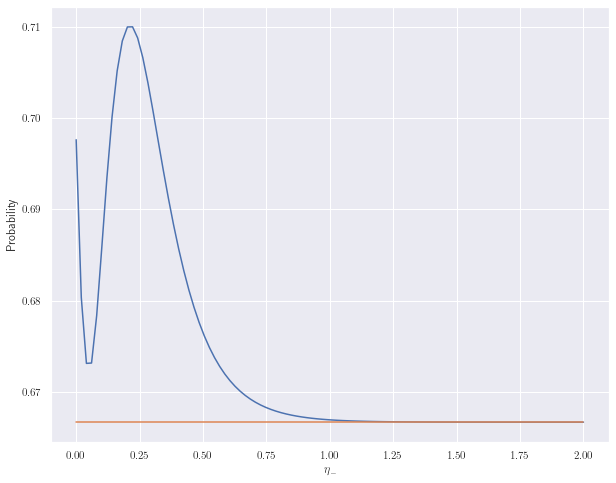

In [ ]:
plt.plot(space, hmap[0, :])
plt.plot(space, [1/2*(1 + 1/K) for i in space])
plt.xlabel('$\eta_-$')
plt.ylabel('Probability')

In [ ]:
min(hmap[:, 0])

(0.6472974553219416+4.000628636544927e-18j)

#### $\gamma_- = 0$

Text(0, 0.5, 'Probability')

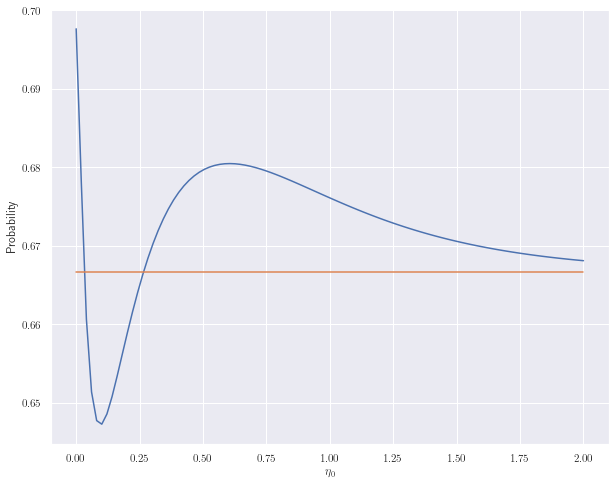

In [ ]:
plt.plot(space, hmap[:, 0])
plt.plot(space, [1/2*(1 + 1/K) for i in space])
plt.xlabel('$\eta_0$')
plt.ylabel('Probability')


In [ ]:
dim = 100
hmap = np.zeros((dim, dim), dtype = complex)
space = np.linspace(0, 0.05, dim)
for m in range(dim):
    sys.stdout.write("\rDoing thing " + str(m))
    sys.stdout.flush()
    for n in range(dim):
        hmap[m, n] = prepared_state_relaxation(sgn_Jx, d, K, space[m], space[n])

Doing thing 99

([<matplotlib.axis.XTick at 0x7fd501485690>,
 [Text(0.5, 0, '$0.0$'),
  Text(11.5, 0, '$0.006$'),
  Text(22.5, 0, '$0.011$'),
  Text(33.5, 0, '$0.017$'),
  Text(44.5, 0, '$0.022$'),
  Text(55.5, 0, '$0.028$'),
  Text(66.5, 0, '$0.033$'),
  Text(77.5, 0, '$0.039$'),
  Text(88.5, 0, '$0.044$'),
  Text(99.5, 0, '$0.05$')])

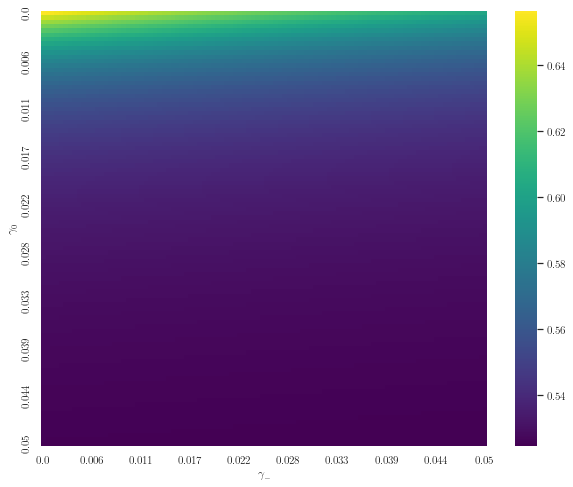

In [ ]:
sns.set(rc={'figure.figsize':(10,8), 'text.usetex':'True'})
num_ticks = 10
sns.heatmap(np.real(hmap), cmap = 'viridis', xticklabels= 11, yticklabels= 11)
plt.xlabel("$\gamma_-$")
plt.ylabel("$\gamma_0$")
ticks = [f"${round(a, 3)}$" for a in np.linspace(0, 0.05, 10)]
plt.yticks(plt.yticks()[0], ticks)
plt.xticks(plt.xticks()[0], ticks)

# Visualizing Wigner function

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def Y(m, l, theta, phi):
    return scipy.special.sph_harm(m, l, theta, phi)

def C_dag(m, l, j):
    d = int(2*j + 1)
    mat = np.zeros((d, d), dtype = complex)
    for r in np.arange(-j, j + 1, 1):
        for s in np.arange(-j, j + 1, 1):
            mat[index(j, r), index(j, s)] = (-1)**(j - r)*cg(j, j, l, r, -s, -m)
    return mat

# cache = dict()
def delta_j(j, theta, phi):
    d = int(2*j + 1)
    res = np.zeros((d, d))
    for l in np.arange(0, int(2*j) + 1, 1):
        for m in np.arange(-l, l + 1, 1):
            res = res + Y(m, l, theta, phi)*C_dag(m, l, j)
    return np.sqrt(4*np.pi/(2*j + 1))*res

def cached_delta_j(j, theta, phi):
    if((j, theta, phi) not in cache):
        res = delta_j(j, theta, phi)
        cache[j, theta, phi] = res
    return cache[j, theta, phi]

def wigner(rho, theta, phi):
    d = np.shape(rho)[0]
    j = (d - 1)/2
    return tr(rho @ cached_delta_j(j, theta, phi))

#lin's definition for theta and phi is different from the one used in the paper
def plot_wigner(rho, phi_samples = 720, theta_samples = 60):
    phi_arr = np.linspace(0, 2*np.pi, phi_samples)
    theta_arr = np.linspace(0, np.pi/2, theta_samples)
    wigner_psi_upper = np.zeros((phi_samples, theta_samples), dtype = complex)
    wigner_psi_lower = np.zeros((phi_samples, theta_samples), dtype = complex)
    for m in range(phi_samples):
        sys.stdout.write("\rCalculating " + str(round(m/(phi_samples)*100)) + "%")
        sys.stdout.flush()
        for n in range(theta_samples):
            wigner_psi_upper[m, n] = wigner(rho, phi_arr[m], theta_arr[n]) #therefore we change the order here
            wigner_psi_lower[m, n] = wigner(rho, phi_arr[m], -theta_arr[n] + np.pi)
    
    rad = theta_arr
    a = phi_arr
    r, th = np.meshgrid(rad, a)

    z_upper = np.real(wigner_psi_upper)
    z_lower = np.real(wigner_psi_lower)
    z_upper_neg = np.sign(z_upper)
    z_lower_neg = np.sign(z_lower)

    fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection="polar"), figsize = (15, 15))
    
    c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
    c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
    c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
    c_lower_neg = ax[1, 1].pcolor(th, r, z_lower_neg, cmap = 'viridis')
    ax[0, 0].grid()
    ax[0, 1].grid()
    ax[1, 0].grid()
    ax[1, 1].grid()
    fig.colorbar(c_upper, ax= ax[0, 0])
    fig.colorbar(c_upper_neg, ax= ax[0, 1])
    fig.colorbar(c_lower, ax= ax[1, 0])
    fig.colorbar(c_lower_neg, ax= ax[1, 1])
    plt.show()


In [ ]:
import pickle
# pickle.dump(cache, open('wigner_720_60.pickle','wb'))
cache = pickle.load(open('wigner_720_60.pickle','rb'))

# Lindblad equation solver

## Spin-$j$ pure dephasing precession

In [ ]:
gamma_m = 0
omega = 2*sp.pi/3
gamma_0 = sp.Rational(1, 2)

In [ ]:
t = symbols('t', positive = True)
j = 7/2
d = int(2*j + 1)
A = sp.zeros(d, d)
S = sgnJx_sp(d)
for m in range(d):
    for n in range(d):
        A[m, n] = sp.expand(time_evol_relaxation(S, m - j, n - j, j, omega, gamma_0, gamma_m, t))
sgnJx_evo = sp.lambdify(t, A, "numpy")

In [ ]:
j = 7/2
d = int(2*j + 1)
K = 7
omega = 2*np.pi/3
gamma_0 = 0.5

qutip mesolve solves for density matrix not operator so there should be a conjugate in this basis. however, the basis order in qutip are chosen in the reverse order as our convention so the result obtained here is the conjugate of our result. therefore, we may only need to introduce a conjugate only when we are solving for density matrix

In [ ]:
j = 7/2
d = int(2*j + 1)
K = 7
H = omega * qt.jmat(j, 'z')
times = [2*np.pi/omega*k/K for k in range(K)]
sgnJx0 = qt.Qobj(sgnJx(d))
result = qt.mesolve(H, sgnJx0, times, [np.sqrt(2*gamma_0) * qt.jmat(j, 'z')])
sgnJx_arr = [operator.full() for operator in result.states] 

TypeError: Incompatible object for multiplication

In [6]:
qt.jmat(1/2, 'x') * qt.jmat(1/2, 'x')

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.25 0.  ]
 [0.   0.25]]

In [ ]:
k = 6
print("average error per entry is ", np.sum(sgnJx_arr[k] - sgnJx_evo(2*np.pi*k/K/omega))/d**2)

average error per entry is  (2.0744560657658093e-07-8.271806125530277e-25j)


## Spin-$7/2$ $D^+$

In [ ]:
j = 7/2
d = int(2*j + 1)
K = 3
Q = 33*1e3
T2 = 1e-2
gamma_n = 5.5*1e6
gamma_0 = 1/T2
B_0 = 1.496
omega = gamma_n * B_0
eta = 0.01
eta_0 = -gamma_0/omega
Jz = qt.jmat(j, 'z')
Jx = qt.jmat(j, 'x')
Jy = qt.jmat(j, 'y')

In [ ]:
H = -omega * Jz + Q*Jz*Jz
times = [2*np.pi/omega*k/K for k in range(K)]
sgnJx0 = qt.Qobj(sgnJx(d))
result = qt.mesolve(H, sgnJx0, times, [np.sqrt(2*gamma_0) * Jz])
sgnJx_arr = [mat.full() for mat in result.states] 

In [ ]:
def sgnJx_evo(gamma_0):
    H = -omega * Jz + Q/3*(3*Jz*Jz - (Jx*Jx + Jy*Jy + Jz*Jz) - eta*(Jx*Jx - Jy*Jy))
    times = [2*np.pi/omega*k/K for k in range(K)]
    sgnJx0 = qt.Qobj(sgnJx(d))
    result = qt.mesolve(H, sgnJx0, times, [np.sqrt(2*gamma_0) * Jz])
    sgnJx_arr = [mat.full() for mat in result.states] 
    Q_K = np.zeros((d, d))
    for mat in sgnJx_arr:
        Q_K = Q_K + mat
    Q_K = Q_K/K
    # plot_wigner(max_eig_vec(Q_K) @ hermitian(max_eig_vec(Q_K)))
    return 1/2*(1 + max_eig_val(Q_K))

Calculating 100%

/tmp/ipykernel_2309/3903069852.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_2309/3903069852.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_2309/3903069852.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_2309/3903069852.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and

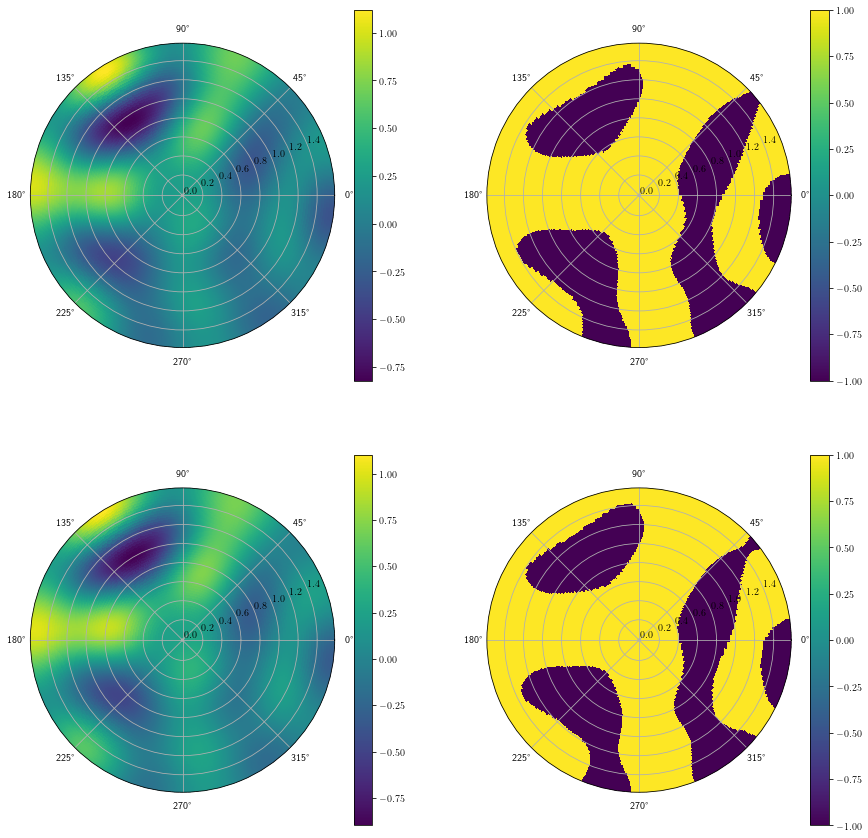

(6.837876766530027e-05+6.929646594881233e-20j)

In [ ]:
sgnJx_evo(gamma_0) - P(d, K)


/home/khoinguyen/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


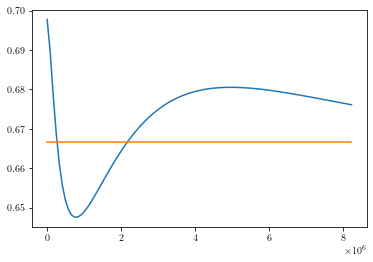

In [ ]:
gamma_arr = np.linspace(0, 1*omega, 101)
score_arr = [sgnJx_evo(gm) for gm in gamma_arr]
plt.plot(gamma_arr, score_arr)
plt.plot(gamma_arr, [1/2*(1 + 1/K) for _ in gamma_arr])

In [ ]:
print(min(score_arr), max(score_arr))

(0.647656936527221-5.414885265105483e-19j) (0.6977470843036998-4.0331039145376515e-18j)


In [ ]:
max(score_arr) - score_arr[0]

(0.0008345307422829018-3.704958376618629e-18j)

In [ ]:
vec_opt = max_eig_vec(Q_K)
rho_opt = vec_opt @ hermitian(vec_opt)

Calculating 100%

/tmp/ipykernel_460/3496857223.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper = ax[0, 0].pcolor(th, r, z_upper, cmap = 'viridis')
/tmp/ipykernel_460/3496857223.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_upper_neg = ax[0, 1].pcolor(th, r, z_upper_neg, cmap = 'viridis')
/tmp/ipykernel_460/3496857223.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_lower = ax[1, 0].pcolor(th, r, z_lower, cmap = 'viridis')
/tmp/ipykernel_460/3496857223.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and wil

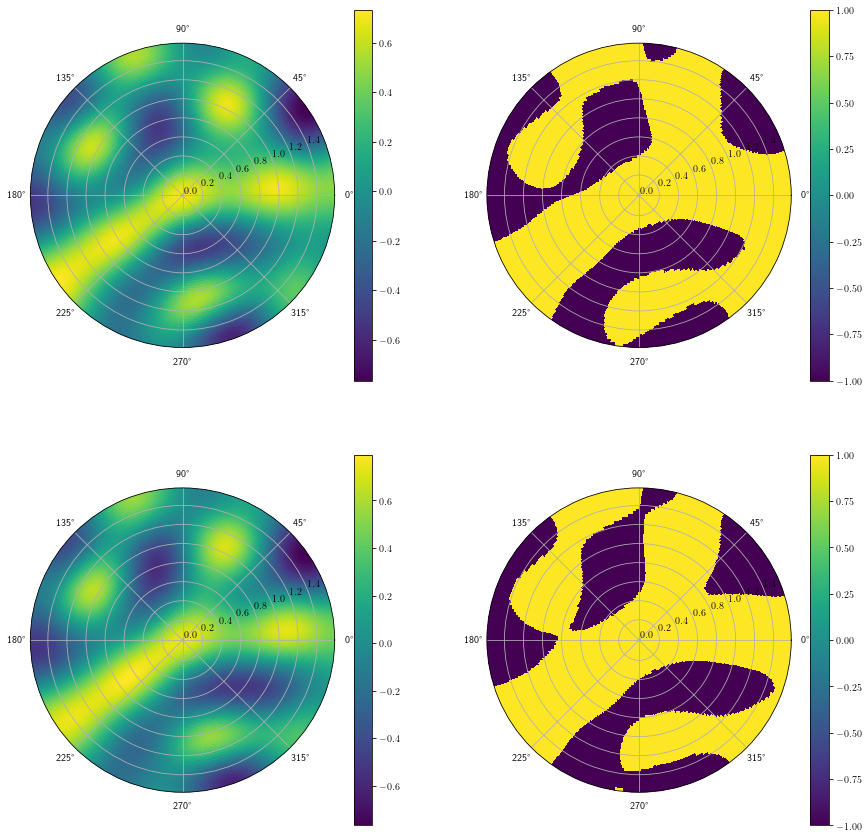

In [ ]:
plot_wigner(rho_opt)

## Diagonalized EFG

In [ ]:
def diagonalized_J(k, theta):
    kx, ky, kz = k
    K = np.array([
        [0, -kz, ky],
        [kz, 0, -kx],
        [-ky, kx, 0]
    ])
    #Rodriguez formula
    R = np.eye(3) + np.sin(theta)*K + (1 - np.cos(theta))*(K @ K) 
    
    Jz = qt.jmat(j, 'z')
    Jx = qt.jmat(j, 'x')
    Jy = qt.jmat(j, 'y')

    Jx_p = R[0, 0]*Jx + R[1, 0]*Jy + R[2, 0]*Jz
    Jy_p = R[0, 1]*Jx + R[1, 1]*Jy + R[2, 1]*Jz
    Jz_p = R[0, 2]*Jx + R[1, 2]*Jy + R[2, 2]*Jz

    return Jx_p, Jy_p, Jz_p

def sgnJx_evo_prime(gamma_0, k, theta):
    j = 7/2
    d = int(2*j + 1)
    K = 3
    Q = 33*1e3
    T2 = 1e-2
    gamma_n = 5.5*1e6
    B_0 = 1.496
    omega = gamma_n * B_0
    eta = 0.01

    Jz = qt.jmat(j, 'z')
    Jx_p, Jy_p, Jz_p = diagonalized_J(k, theta) 

    H = -omega * Jz + Q/3*(3*Jz_p*Jz_p - (Jx_p*Jx_p + Jy_p*Jy_p + Jz_p*Jz_p) - eta*(Jx_p*Jx_p - Jy_p*Jy_p))
    times = [2*np.pi/omega*k/K for k in range(K)]
    sgnJx0 = qt.Qobj(sgnJx(d))
    result = qt.mesolve(H, sgnJx0, times, [np.sqrt(2*gamma_0) * Jz])
    sgnJx_arr = [mat.full() for mat in result.states] 
    Q_K = np.zeros((d, d))
    for mat in sgnJx_arr:
        Q_K = Q_K + mat
    Q_K = Q_K/K
    # plot_wigner(max_eig_vec(Q_K) @ hermitian(max_eig_vec(Q_K)))
    return 1/2*(1 + max_eig_val(Q_K))

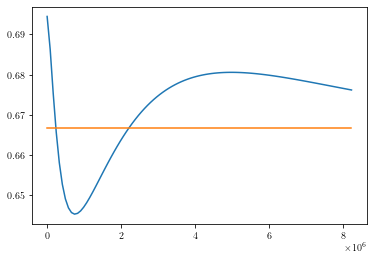

In [ ]:
theta = np.pi/5
k = np.random.rand(3)
k = k/la.norm(k)
gamma_arr = np.linspace(0, 1*omega, 101)
score_arr = [sgnJx_evo_prime(gm, k, theta) for gm in gamma_arr]
plt.plot(gamma_arr, score_arr)
plt.plot(gamma_arr, [1/2*(1 + 1/K) for _ in gamma_arr])

In [ ]:
print(min(score_arr), max(score_arr))

(0.645903110713925+3.026234884771732e-18j) (0.6952677732561335+2.612579154471191e-17j)


# Classical quadrupole 

## Simple model

In [54]:
def quadr_de(t, w, omega, alpha):
    x, y, px, py = w

    f = [-(omega + 2*alpha*(x*py - y*px))*y,
         (omega + 2*alpha*(x*py - y*px))*x,
         -(omega + 2*alpha*(x*py - y*px))*py,
         (omega + 2*alpha*(x*py - y*px))*px]
    return f

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((- ang1 + ang2) % (2 * np.pi))

328.98469668041764

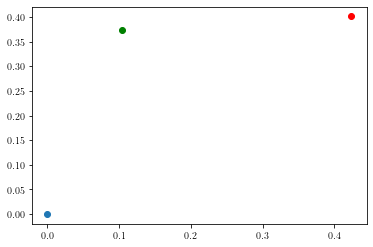

In [62]:
xx = 2*np.random.rand(2) - 1
yy = 2*np.random.rand(2) - 1
plt.plot(xx[0], yy[0], marker='o', color = 'g')
plt.plot(xx[1], yy[1], marker='o', color = 'r')
plt.plot(0, 0, marker='o')
angle_between([xx[0], yy[0]], [xx[1], yy[1]])

In [ ]:
k_arr = np.linspace(0.1, 1,  1000)
T_arr = []
for k in k_arr:
    print(k)
    alpha = 0.01
    omega = 1
    E = 1
    x = 1
    z = 1
    pz = 1
    r = 1
    Lx = 0
    Ly = 1

    E = k
    px = (Ly + x*pz)/z
    Lz = E/omega
    py = (-Lz*pz - Lx*px)/Ly
    y = (-Lx*x - Lz*z)/Ly
    n = 2
    w0 = [x, y, px, py]
    res = solve_ivp(quadr_de, [0, n*2*np.pi/(omega)], w0, args=[omega, alpha], dense_output=True)

    step = 100000
    t = np.linspace(0, n*2*np.pi/(omega), step)
    res_t = res.sol(t)
    x_arr = [res_t[0, _] for _ in range(np.shape(res_t)[1])]
    y_arr = [res_t[1, _] for _ in range(np.shape(res_t)[1])]
    px_arr = [res_t[2, _] for _ in range(np.shape(res_t)[1])]
    py_arr = [res_t[3, _] for _ in range(np.shape(res_t)[1])]

    Lx_arr = [y_arr[i]*pz - z*py_arr[i] for i in range(step)]
    Ly_arr = [-x_arr[i]*pz + z*px_arr[i] for i in range(step)]
    is_neg = False
    # start_index = stop_index = start_time = stop_time = 0
    # for i in range(len(Lx_arr)):
    #     if(Lx_arr[i] < 0 and not is_neg):
    #         start_index = i
    #         start_time = t[i]*omega/(2*np.pi)
    #         is_neg = True
    #     if(Lx_arr[i] > 0 and is_neg):
    #         stop_index = i
    #         stop_time = t[i]*omega/(2*np.pi)
    #         break
    # print(stop_time - start_time)
    agl = angle_between([Lx_arr[0], Ly_arr[0]], [Lx_arr[-1], Ly_arr[-1]])
    # print(agl)
    # plt.figure(figsize=(10,10))
    # plt.gca().set_aspect('equal')
    # plt.plot(Lx_arr, Ly_arr)
    # plt.plot(Lx_arr[0], Ly_arr[0], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
    # plt.plot(Lx_arr[-1], Ly_arr[-1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="orange")
    for i in range(1, step - 1):
        if(Lx_arr[i] >= 0 and Lx_arr[i+1] < 0):
            T_arr.append(i*n/step)
            break
        # plt.plot(Lx[i+1], Ly[i+1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="orange")
        
# plt.plot(Lx[start_index], Ly[start_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="blue")
# plt.plot(Lx[stop_index], Ly[stop_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="cyan")



[1, 0.0, 2.0, -0.0] 0 1 0.0
0.08820423344269324


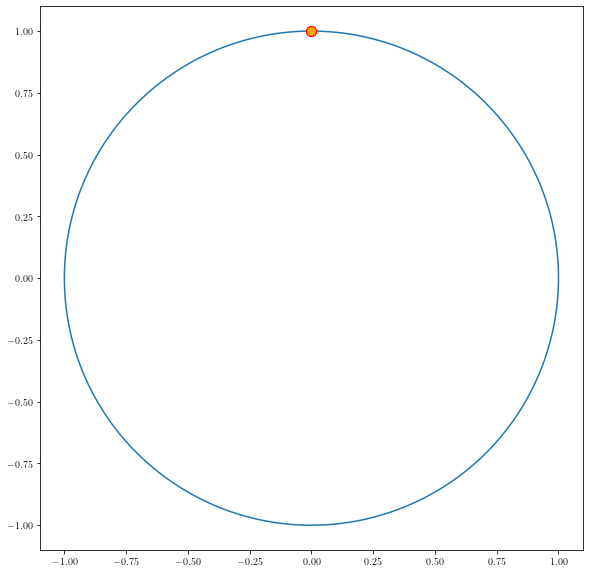

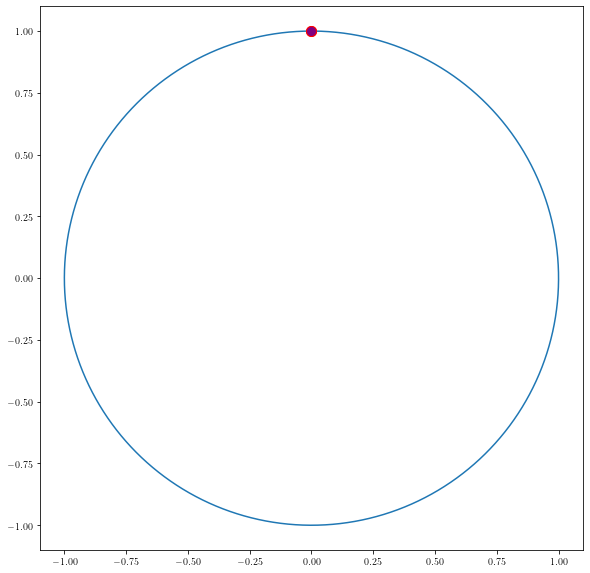

In [63]:
alpha = 0.01
omega = 1
E = 0
x = 1
z = 1
pz = 1
Lx = 0
Ly = 1

px = (Ly + x*pz)/z
Lz = E/omega
py = (-Lz*pz - Lx*px)/Ly
y = (-Lx*x - Lz*z)/Ly
n = 1
w0 = [x, y, px, py]
print(w0, Lx, Ly, Lz)
res = solve_ivp(quadr_de, [0, n*2*np.pi/(omega)], w0, args=[omega, alpha], dense_output=True)
step = 10000
t = np.linspace(0, n*2*np.pi/(omega), step)
res_t = res.sol(t)

x_arr = [res_t[0, _] for _ in range(np.shape(res_t)[1])]
y_arr = [res_t[1, _] for _ in range(np.shape(res_t)[1])]
px_arr = [res_t[2, _] for _ in range(np.shape(res_t)[1])]
py_arr = [res_t[3, _] for _ in range(np.shape(res_t)[1])]

Lx_arr = [y_arr[i]*pz - z*py_arr[i] for i in range(step)]
Ly_arr = [-x_arr[i]*pz + z*px_arr[i] for i in range(step)]

agl = angle_between([Lx_arr[0], Ly_arr[0]], [Lx_arr[-1], Ly_arr[-1]])
print(agl)

plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
plt.plot(Lx_arr, Ly_arr)
plt.plot(Lx_arr[0], Ly_arr[0], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.plot(Lx_arr[-1], Ly_arr[-1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="orange")

Lx_per = [Ly*np.cos((omega + 2*alpha*Lz)*t_ + np.pi/2) for t_ in t]
Ly_per = [Ly*np.sin((omega + 2*alpha*Lz)*t_ + np.pi/2) for t_ in t]
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
plt.plot(Lx_per, Ly_per)
plt.plot(Lx_per[0], Ly_per[0], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.plot(Lx_per[-1], Ly_per[-1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="purple")
# plt.plot(Lx_per[start_index], Ly_per[start_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="blue")
# plt.plot(Lx_per[stop_index], Ly_per[stop_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="cyan")

## Complete model

In [ ]:
x, y, z, px, py, pz, Lx, Ly, Lz, Lxp, Lyp, Lzp, k, theta, omega, alpha, eta = symbols(f'x y z p_x p_y p_z L_x L_y L_z L_x^\' L_y^\' L_z^\' k \\theta \\omega alpha, eta')
Rxx, Rxy, Rxz, Ryx, Ryy, Ryz, Rzx, Rzy, Rzz = symbols(f"R_{'xx'} R_{'xy'} R_{'xz'} R_{'yx'} R_{'yy'} R_{'yz'} R_{'zx'} R_{'zy'} R_{'zz'}")

Lx = y*pz - z*py
Ly = z*px - x*pz
Lz = x*py - y*px

Lxp = Rxx*Lx + Rxy*Ly + Rxz*Lz
Lyp = Ryx*Lx + Ryy*Ly + Ryz*Lz
Lzp = Rzx*Lx + Rzy*Ly + Rzz*Lz

H = omega*Lz + alpha/2*(2*Lz**2 + (eta - 1)*Lx**2 -(eta + 1)*Ly**2)
-sp.diff(H, x)

-\omega*p_y - alpha*(4*p_y*(-p_x*y + p_y*x) + 2*p_z*(eta + 1)*(p_x*z - p_z*x))/2

In [4]:
def rodriguez_mat(k, theta):
    kx, ky, kz = k
    K = np.array([
        [0, -kz, ky],
        [kz, 0, -kx],
        [-ky, kx, 0]
    ])
    return np.eye(3) + np.sin(theta)*K + (1 - np.cos(theta))*(K @ K)

def quadr_de_prime(t, w, omega, alpha, eta, R):
    x, y, z, px, py, pz = w
    Lx = y*pz - z*py
    Ly = z*px - x*pz
    Lz = x*py - y*px
    Lxp = R[0, 0]*Lx + R[0, 1]*Ly + R[0, 2]*Lz
    Lyp = R[1, 0]*Lx + R[1, 1]*Ly + R[1, 2]*Lz
    Lzp = R[2, 0]*Lx + R[2, 1]*Ly + R[2, 2]*Lz
    f = [-omega*y + alpha*(2*Lzp*(R[2, 1]*z - R[2, 2]*y) + (eta - 1)*Lxp*(R[0, 1]*z - R[0, 2]*y) - (eta + 1)*Lyp*(R[1, 1]*z - R[1, 2]*y)),
        omega*x + alpha*(2*Lzp*(R[2, 2]*x - R[2, 0]*z) + (eta - 1)*Lxp*(R[0, 2]*x - R[0, 0]*z) - (eta + 1)*Lyp*(R[1, 2]*x - R[1, 0]*z)),
         alpha*(2*Lzp*(R[2, 0]*y - R[2, 1]*x) + (eta - 1)*Lxp*(R[0, 0]*y - R[0, 1]*x) - (eta + 1)*Lyp*(R[1, 0]*y - R[1, 1]*x)),
        -omega*py + alpha*(2*Lzp*(R[2, 1]*pz - R[2, 2]*py) + (eta - 1)*Lxp*(R[0, 1]*pz - R[0, 2]*py) - (eta + 1)*Lyp*(R[1, 1]*pz - R[1, 2]*py)),
        omega*px + alpha*(2*Lzp*(R[2, 2]*px - R[2, 0]*pz) + (eta - 1)*Lxp*(R[0, 2]*px - R[0, 0]*pz) - (eta + 1)*Lyp*(R[1, 2]*px - R[1, 0]*pz)),
         alpha*(2*Lzp*(R[2, 0]*py - R[2, 1]*px) + (eta - 1)*Lxp*(R[0, 0]*py - R[0, 1]*px) - (eta + 1)*Lyp*(R[1, 0]*py - R[1, 1]*px))]
    return f


    

### $\frac{T}{\tilde{T}}$

In [619]:
theta = 0
k = np.random.rand(3)
k = k/la.norm(k)

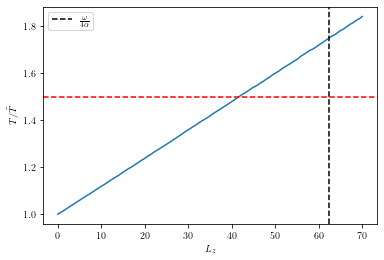

In [630]:
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"

alpha = 33*1e3 #Q
T2 = 1e-2
gamma_n = 5.5*1e6
B_0 = 1.496
omega = gamma_n * B_0
eta = 0.01

x = np.random.uniform(0, 100)
z = np.random.uniform(0, 100)
pz = np.random.uniform(0, 100)
Lx = 0
Ly = 100
# Lz = 1

k_arr = np.linspace(0, 70, 100)
T_arr = []
for Lz in k_arr:
    y = -(x*Lx + z*Lz)/Ly
    px = (Ly + x*pz)/z
    py = (-Lx + y*pz)/z
    n = 1
    w0 = [x, y, z, px, py, pz]
    res = solve_ivp(quadr_de_prime, [0, n*2*np.pi/(omega)], w0, args=[omega, alpha, eta, rodriguez_mat(k, theta)], dense_output=True)

    step = 1000
    t = np.linspace(0, n*2*np.pi/(omega), step)
    res_t = res.sol(t)
    x_arr = [res_t[0, _] for _ in range(np.shape(res_t)[1])]
    y_arr = [res_t[1, _] for _ in range(np.shape(res_t)[1])]
    z_arr = [res_t[2, _] for _ in range(np.shape(res_t)[1])]
    px_arr = [res_t[3, _] for _ in range(np.shape(res_t)[1])]
    py_arr = [res_t[4, _] for _ in range(np.shape(res_t)[1])]
    pz_arr = [res_t[5, _] for _ in range(np.shape(res_t)[1])]

    Lx_arr = [y_arr[i]*pz_arr[i] - z_arr[i]*py_arr[i] for i in range(step)]
    Ly_arr = [z_arr[i]*px_arr[i] - x_arr[i]*pz_arr[i] for i in range(step)]
    Lz_arr = [x_arr[i]*py_arr[i] - y_arr[i]*px_arr[i] for i in range(step)]

    pos = False
    for i in range(step):
        if(not pos and Lx_arr[i] > 1e-8):
            pos = True
        if(pos and Lx_arr[i] < 0):
            T_arr.append(i/step)
            break
        if(i == step - 1):
            print(Lz)

# plt.figure(figsize=(10,10))
# plt.gca().set_aspect('equal')
# plt.plot(Lx_arr, Ly_arr)
# plt.plot(Lx_arr[0], Ly_arr[0], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
# plt.plot(Lx_arr[-1], Ly_arr[-1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="orange")

plt.plot(k_arr, [1/T for T in T_arr])
plt.xlabel('$L_z$')
plt.ylabel(f'$T/\\tilde{{T}}$')
plt.axvline(omega/(4*alpha), linestyle = "--", color = 'black', label = f"$\\frac{{\\omega}}{{4\\alpha}}$")
plt.axhline(3/2, linestyle = "--", color = 'red')
plt.legend()

### $\Delta t_-$ and $\Delta t_+$

In [64]:
theta = 2*np.pi/100
k = np.random.rand(3)
k = k/la.norm(k)

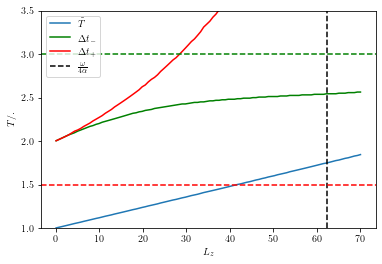

In [69]:
Q = 33*1e3
alpha = Q
T2 = 1e-2
gamma_n = 5.5*1e6
B_0 = 1.496
omega = gamma_n * B_0
eta = 0.01

x = np.random.uniform(0, 100)
z = np.random.uniform(0, 100)
pz = np.random.uniform(0, 100)
Lx = 0
Ly = 2
# Lz = 1

k_arr = np.linspace(0.1, 70, 100)
T_arr = []
delta_plus_arr = []
delta_minus_arr = []
for Lz in k_arr:
    y = -(x*Lx + z*Lz)/Ly
    px = (Ly + x*pz)/z
    py = (-Lx + y*pz)/z
    n = 1
    w0 = [x, y, z, px, py, pz]
    res = solve_ivp(quadr_de_prime, [0, n*2*np.pi/(omega)], w0, args=[omega, alpha, eta, rodriguez_mat(k, theta)], dense_output=True)

    step = 1000
    t = np.linspace(0, n*2*np.pi/(omega), step)
    res_t = res.sol(t)
    x_arr = [res_t[0, _] for _ in range(np.shape(res_t)[1])]
    y_arr = [res_t[1, _] for _ in range(np.shape(res_t)[1])]
    z_arr = [res_t[2, _] for _ in range(np.shape(res_t)[1])]
    px_arr = [res_t[3, _] for _ in range(np.shape(res_t)[1])]
    py_arr = [res_t[4, _] for _ in range(np.shape(res_t)[1])]
    pz_arr = [res_t[5, _] for _ in range(np.shape(res_t)[1])]

    Lx_arr = [y_arr[i]*pz_arr[i] - z_arr[i]*py_arr[i] for i in range(step)]
    Ly_arr = [z_arr[i]*px_arr[i] - x_arr[i]*pz_arr[i] for i in range(step)]
    Lz_arr = [x_arr[i]*py_arr[i] - y_arr[i]*px_arr[i] for i in range(step)]

    pos = False
    delta_minus = delta_plus = t_tilde = 0
    for i in range(step):
        if(not pos and Lx_arr[i] > 1e-8):
            pos = True
            minus_index = i 
        elif(pos and Lx_arr[i] < 0):
            plus_index = i
            break

    delta_minus = minus_index/step
    delta_plus = (plus_index - minus_index)/step
    T_tilde = plus_index/step
    delta_minus_arr.append(delta_minus)
    delta_plus_arr.append(delta_plus)
    T_arr.append(T_tilde)
# plt.figure(figsize=(10,10))
# plt.gca().set_aspect('equal')
# plt.plot(Lx_arr, Ly_arr)
# plt.plot(Lx_arr[0], Ly_arr[0], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
# plt.plot(Lx_arr[-1], Ly_arr[-1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="orange")

plt.plot(k_arr, [1/T for T in T_arr], label = f'$\\tilde{{T}}$')
plt.plot(k_arr, [1/T for T in delta_minus_arr], label=f'$\\Delta t_-$', color = 'green')
plt.plot(k_arr, [1/T for T in delta_plus_arr], label=f'$\\Delta t_+$', color = 'red')
plt.xlabel('$L_z$')
plt.ylabel(f'$T/.$')
plt.axvline(omega/(4*alpha), linestyle = "--", color = 'black', label = f"$\\frac{{\\omega}}{{4\\alpha}}$")
plt.axhline(3/2, linestyle = "--", color = 'red')
plt.axhline(3, linestyle = "--", color = 'green')
plt.ylim(1, 3.5)
plt.legend()

In [686]:
np.polyfit(k_arr, [1/T for T in T_arr], 1)[0]/(alpha/omega)

3.0054074398490016

### Animation

In [312]:
theta = 2*np.pi/360
k = np.concatenate((np.random.rand(2), [0]), )
k = k/la.norm(k)

In [271]:
rodriguez_mat(k, theta)

array([[ 9.99999997e-01,  6.88888447e-07,  7.89396047e-05],
       [ 6.88888447e-07,  9.99847698e-01, -1.74522279e-02],
       [-7.89396047e-05,  1.74522279e-02,  9.99847695e-01]])

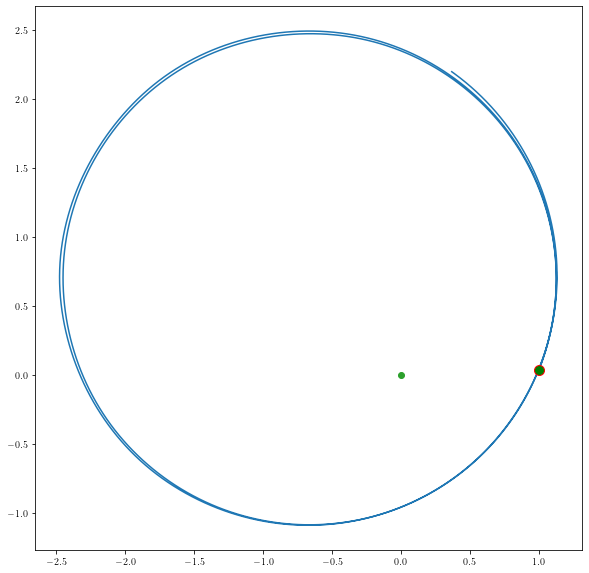

[0.72492192 0.68883104 0.        ]


In [325]:

Q = 33*1e3 #Q
alpha = Q
T2 = 1e-2
gamma_n = 5.5*1e6
B_0 = 1.496
omega = gamma_n * B_0
eta = 0.01

x = np.random.uniform(0, 100)
z = np.random.uniform(0, 100)
pz = np.random.uniform(0, 100)
Lz = 100
# L = np.sqrt(Lz**2 + 100**2)
Lxy = 1
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
# np.linspace(0.01*np.pi, 1.99*np.pi, 100)
for phi in [2*np.pi*u/201 for u in range(1, 2)]:
    Lx = Lxy*np.cos(phi)
    Ly = Lxy*np.sin(phi)

    y = -(x*Lx + z*Lz)/Ly
    px = (Ly + x*pz)/z
    py = (-Lx + y*pz)/z
    n = 1
    w0 = [x, y, z, px, py, pz]
    # print(w0, Lx, Ly, Lz, phi)
    res = solve_ivp(quadr_de_prime, [0, n*2*np.pi/(omega)], w0, args=[omega, alpha, eta, rodriguez_mat(k, theta)], dense_output=True)

    step = 1000
    t = np.linspace(0, n*2*np.pi/(omega), step)
    res_t = res.sol(t)
    x_arr = [res_t[0, _] for _ in range(np.shape(res_t)[1])]
    y_arr = [res_t[1, _] for _ in range(np.shape(res_t)[1])]
    z_arr = [res_t[2, _] for _ in range(np.shape(res_t)[1])]
    px_arr = [res_t[3, _] for _ in range(np.shape(res_t)[1])]
    py_arr = [res_t[4, _] for _ in range(np.shape(res_t)[1])]
    pz_arr = [res_t[5, _] for _ in range(np.shape(res_t)[1])]

    Lx_arr = [y_arr[i]*pz_arr[i] - z_arr[i]*py_arr[i] for i in range(step)]
    Ly_arr = [z_arr[i]*px_arr[i] - x_arr[i]*pz_arr[i] for i in range(step)]
    Lz_arr = [x_arr[i]*py_arr[i] - y_arr[i]*px_arr[i] for i in range(step)]

    plt.plot(Lx_arr, Ly_arr)
    plt.plot(Lx_arr[0], Ly_arr[0], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
    # plt.plot(Lx_arr[-1], Ly_arr[-1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="orange")
plt.plot(0, 0, marker='o')
agl_arr = np.linspace(0, 2*np.pi, 1000)
# plt.xlim(-10,10)
# plt.ylim(-10,10)
# plt.plot([Lxy*np.cos(agl) for agl in agl_arr], [Lxy*np.sin(agl) for agl in agl_arr])
plt.show()
print(k)

In [416]:
ani